# Detección de frases verificables

In [26]:
import os
from os.path import join, exists
os.chdir("..")

In [50]:
import pandas as pd
import transformers
import plotly.express as px

# Preprocessing
from src.preprocess import translate_google as translator
from src.preprocess import preprocess_spacy as nlp_prep
from src.preprocess import prepare_model_data as model_prep

# Model
from src.model import finetune_bert as trainer
from src.model import evaluate_bert as evaluator
from src.model import tensorboard_utils

# Change transformers logger level
transformers.logging.set_verbosity_error()

In [3]:
# Path variables
data_dirpath = "/home/agusriscos/verifiable-phrase-detection/data"
raw_input_filepath = join(data_dirpath, "ml_test_data.csv")
da_input_dirpath = join(data_dirpath, "data-augmentation/input")
da_output_filepath = join(data_dirpath, "data-augmentation/output/out_da_train.csv")

training_dirpath = "/home/agusriscos/verifiable-phrase-detection/training/bert"
trainlog_dirpath = join(training_dirpath, "train-logs")
testlog_dirpath = join(training_dirpath, "test-logs")

In [4]:
# Bert model used
model_name = "dccuchile/bert-base-spanish-wwm-cased" # https://users.dcc.uchile.cl/~jperez/papers/pml4dc2020.pdf

In [5]:
# Raw dataframe
claim_df = pd.read_csv(raw_input_filepath)
print("Number of raw documents:", claim_df.shape[0])

Number of raw documents: 15000


## 1. Análisis descriptivo

### 1.1 Análisis simple y evaluación de la variable objetivo

In [6]:
# Missing values?
for column in claim_df.columns:
    print("Column \"{0}\" has {1} missing values".format(column, claim_df[column].isna().sum()))

Column "text" has 0 missing values
Column "claim" has 0 missing values


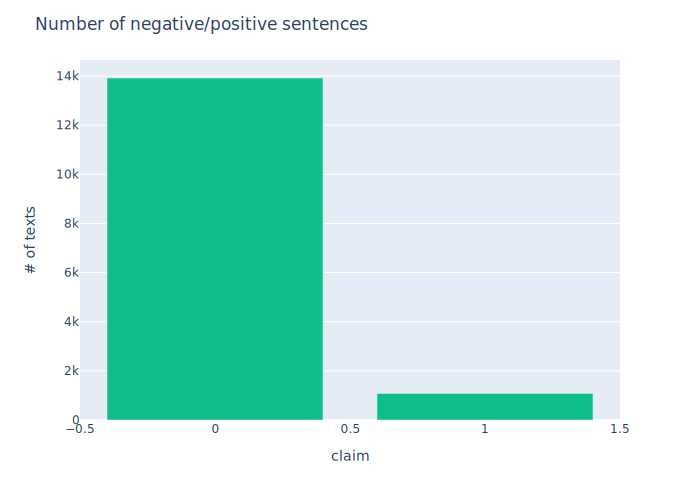

In [7]:
# Imbalanced distribution of target variable? YES
label_count = claim_df["claim"].value_counts().reset_index()
fig = px.bar(label_count, x="index", y="claim")
fig.update_traces(marker_color="#0ebf8c")
fig.update_layout(title="Number of negative/positive sentences", xaxis_title="claim", yaxis_title="# of texts")
fig.show("svg")

 <strong>Hay desbalance de clases</strong>. Esto afecta al entrenamiento del detector por lo que intentaremos resolver esto más adelante (eliminación de ruido en la clase negativa y 'data augmentation').

### 1.2 Análisis de palabras

Con este análisis pretendemos identificar diferencias entre clases con respecto a la longitud de sus frases y el número de palabras significativas.  
<strong>Reglas para el filtrado de palabras</strong>:
  - No se quitan los valores numéricos (dos, 30...) para intentar detectar frases verificables que expresen cantidad. Ejemplo: "El paro en España ha subido un 20%" 
  - No se quitan los pronombres (yo, ellos, nosotros...) para intentar detectar frases no verificables basadas en experiencias personales. Ejemplo: "Yo hoy me he levantado a las 7 de la mañana"

In [8]:
claim_pipeline = nlp_prep.load_processing_pipeline() # load 'es_core_news_sm' model

In [9]:
# Count words after simple tokenization (removing punctuation)
for token_function, col_name in zip([nlp_prep.tokenize, nlp_prep.filter_significant_words],
                                    ["num_words", "num_significant_words"]):
    claim_df[col_name] = claim_df["text"].apply(
        lambda x: len(token_function(claim_pipeline, x))
    )

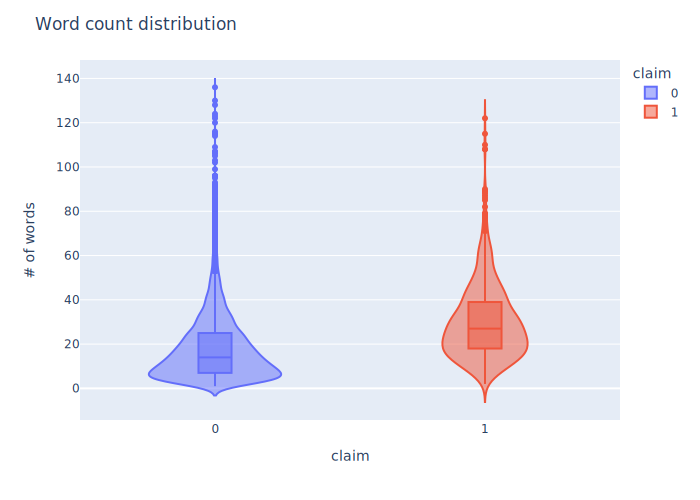

In [10]:
fig = px.violin(claim_df, x="claim", y="num_words", color="claim", box=True)
fig.update_layout(title="Word count distribution", yaxis_title="# of words")
fig.show("svg")

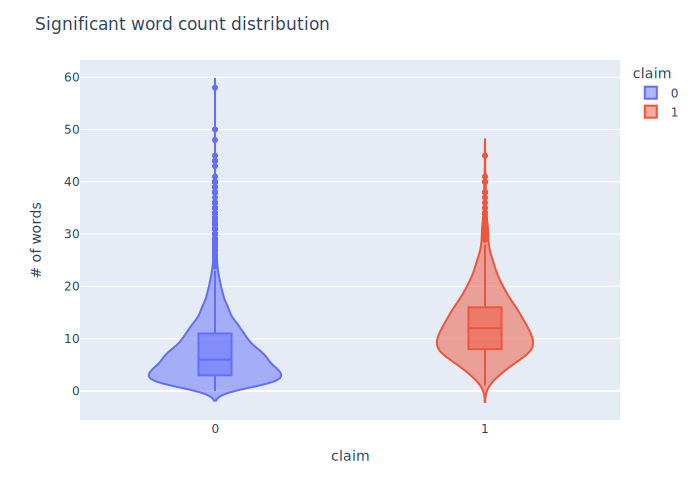

In [11]:
fig = px.violin(claim_df, x="claim", y="num_significant_words", color="claim", box=True)
fig.update_layout(title="Significant word count distribution", yaxis_title="# of words")
fig.show("svg")

Ya en las gráficas de caja podemos observar que las frases verificables suelen tener mayor longitud y mayor numero de palabras significativas. Este es un dato importante a la hora de preparar los datos de entrenamiento del modelo.

In [12]:
# Sample of claims (positive sentences) with few significant words.
pos_claim_with_few_sigwords = claim_df.loc[(claim_df["num_significant_words"] <= 1) & (claim_df["claim"] == 1)]
print("{} positive claims with few significant words\n".format(
    pos_claim_with_few_sigwords.shape[0]))
print(pos_claim_with_few_sigwords.text)

2 positive claims with few significant words

5718               La ciudadanía.
11463    Son de las más modernas.
Name: text, dtype: object


En la clase positiva nos encontramos algunas frases con pocas palabras significativas que no favorecen el aprendizaje del modelo. Sin embargo, al tener un numero tan bajo de frases verificables, optamos por no eliminarlas del dataset.

### 1.3 Análisis del idioma

El objetivo del modelo es detectar automáticamente frases verificables únicamente en <strong>español</strong>. Por lo tanto, resulta interesante analizar el idioma de los documentos. 

<strong>Detección automática del idioma con Google Cloud Platform</strong>

In [13]:
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "./speech2text-323505-6f8076112948.json"
translate_client = translator.get_translation_client()

In [14]:
# Detect language of all texts
claim_df["language"], claim_df["language_detection_confidence"] = zip(*claim_df["text"].map(
    lambda x: translator.detect_language(translate_client, x)))

print("{}% of texts whose language has been perfectly detected".format(
    round(claim_df.loc[claim_df["language_detection_confidence"] == 1].shape[0]/claim_df.shape[0] * 100, 2)
))

96.63% of texts whose language has been perfectly detected


In [15]:
# Get list of dataset languages
language_iso_list = list(claim_df["language"].unique())
language_list = translator.get_language_names(language_iso_list)
print("Language list:", ", ".join(language_list))

Language list: Spanish, Catalan, Galician, Portuguese, Somali, Italian, Undetermined, English, Romanian, Polish, Danish, French, Indonesian, Swedish, Latvian, Japanese, Hindi, Finnish, Lithuanian, Malagasy


In [17]:
# Are there claims in other languages?
text_to_replace = claim_df.loc[(claim_df["language"] != "es") & (claim_df["claim"] == 1)][["text", "language"]]
print("Are there claims in other languages?", True if text_to_replace.shape[0] > 0 else False)

Are there claims in other languages? True


Para poder hacer uso del máximo número de muestras de la clase positiva, se procede a traducir las frases verificables en otros idiomas que se han encontrado durante la realización del análisis.

In [19]:
# Replace text translating into spanish (only claims in other languages)
translated_text = list(text_to_replace.apply(
    lambda x: translator.translate(translate_client, x["text"], x["language"], "es"), axis=1).values)
claim_df.replace(list(text_to_replace["text"]), translated_text, inplace=True)

Ahora se quiere saber cuál es la distribución del número de documentos que no han sido perfectamente traducidos.

Number of documents with very low language detection confidence (c < 0.8): 165


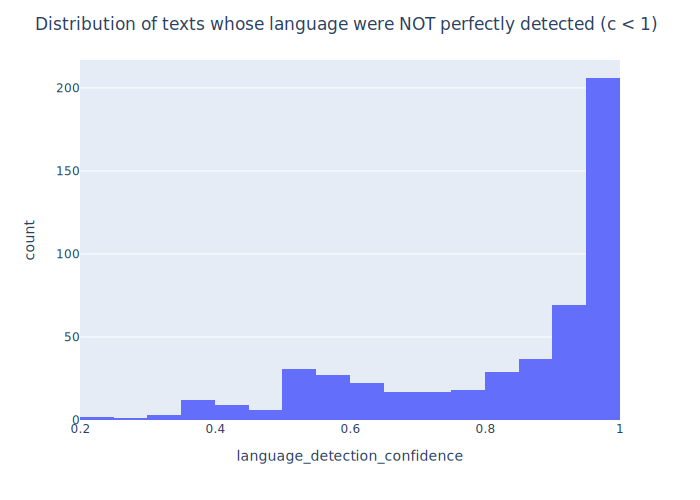

In [20]:
not_well_langdet_df = claim_df.loc[claim_df["language_detection_confidence"] < 0.8]
print("Number of documents with very low language detection confidence (c < 0.8):", not_well_langdet_df.shape[0])# Distribution of text whose language has NOT been perfectly detected (confidence < 1)
langdet_confidence_distribution = claim_df.loc[claim_df["language_detection_confidence"] != 1]
fig = px.histogram(langdet_confidence_distribution, x="language_detection_confidence")
fig.update_layout(title="Distribution of texts whose language were NOT perfectly detected (c < 1)")
fig.show('svg')

In [24]:
print("Number of documents with very low language detection confidence (c < 0.8): {}\n".format(
    not_well_langdet_df.shape[0]))
dummy_df = not_well_langdet_df.sample(10).apply(
    lambda x: print(x["text"], round(x["language_detection_confidence"], 2)), axis=1
)

Number of documents with very low language detection confidence (c < 0.8): 165

Carlos. 0.44
Borja. 0.54
permanece. 0.54
Está validada 0.49
230 plazas Edwards. 0.69
que 0.5
Canadá. 0.7
Por tanto, esta ciudad de administrativa de San Caetano da ose un paso importante licitando a remodelación completa de un dos edificios que data de 1975. 0.52
Vamos a ver, vamos. 0.5
Hartito. 0.52


Como podemos observar en la anterior celda, las frases que han sido detectadas con un nivel bajo de confianza tienen un menor número de palabras significativas y una calidad gramatical baja. Por tanto, podemos utilizar el ratio de confianza de la detección de idioma como otro criterio a la hora de balancear clases.

## 2. Entrenamiento

### 2.1 Preparación de los datos de entrenamiento

En la preparación de los datos optamos por aplicar diferentes técnicas de <strong>data augmentation</strong>:

 - reemplazo de sinónimos
 - inserción aleatoria de palabras
 - intercambio aleatorio de palabras
 - eliminación aleatoria de palabras
 - back-translation

In [22]:
# Train and test split (with significant representations of both labels) before transformations
# to avoid data leakage
train_df, val_df, test_df = model_prep.train_val_test_split(claim_df, output_dirpath=data_dirpath)

# Translate train claims into english for data augmentation purposes
translator.prepare_for_data_augmentation(translate_client, train_df, output_dirpath=da_input_dirpath)

In [28]:
# Back translate en-es for data augmentation (only claim sentences)
# Execute EDA augment.py script before this.
if exists(da_output_filepath):
    output_da_df = pd.read_csv(da_output_filepath, names=["claim", "en_text"], sep="\t")
else:
    print("The back-translation cannot be performed because the file is not found.")
    sys.exit()

bt_train_df = translator.back_translate_claims(translate_client, output_da_df, output_dirpath=data_dirpath)
print(bt_train_df.head())

   claim                                               text
0      1  ahora ya hablamos de cuatro generaciones de es...
1      1  hoy ya hablamos de cuatro generaciones de espa...
2      1  hoy ya hablamos de cuatro generaciones de espa...
3      1  hoy estamos hablando de cuatro generaciones de...
4      1  hoy ya hablamos de cuatro generaciones de espa...


Estos son los pasos que se han seguido para preparar el conjunto de entrenamiento:  
- Eliminar las frases negativas con pocas palabras significativas.  
- Eliminar las frases negativas con peor confianza en la detección del lenguaje.  
- Añadir más filas con las técnicas de data augmentation antes descritas.  
- Aplicar el equilibrio de clases reduciendo la clase negativa de los datos restantes.     

In [29]:
train = pd.read_csv(join(data_dirpath, "raw_train.csv"))
bt_train = pd.read_csv(join(data_dirpath, "bt_train.csv"))
prep_train = model_prep.prepare_training_data(claim_pipeline, train, bt_train, data_dirpath)
prep_train["claim"].value_counts()

1    8887
0    8887
Name: claim, dtype: int64

### 2.2 Entrenamiento

In [35]:
train_dataset, val_dataset = trainer.get_hugging_datasets(prep_train, val_df,
                                                          "dccuchile/bert-base-spanish-wwm-cased")

In [39]:
model = transformers.AutoModelForSequenceClassification.from_pretrained("dccuchile/bert-base-spanish-wwm-cased",
                                                                            num_labels=2)
training_args = transformers.TrainingArguments(output_dir=training_dirpath, overwrite_output_dir=True,
                                               num_train_epochs=3, logging_dir=trainlog_dirpath, 
                                               logging_steps=100, evaluation_strategy="steps",
                                               eval_steps=100, learning_rate=2e-5, per_device_train_batch_size=4,
                                               per_device_eval_batch_size=4, save_steps=100)

trainer_hf = transformers.Trainer(model=model, args=training_args, train_dataset=train_dataset,
                               eval_dataset=val_dataset, compute_metrics=trainer.compute_metrics)
trainer_hf.train()

***** Running training *****
  Num examples = 17774
  Num Epochs = 3
  Instantaneous batch size per device = 4
  Total train batch size (w. parallel, distributed & accumulation) = 4
  Gradient Accumulation steps = 1
  Total optimization steps = 13332
***** Running Evaluation *****
  Num examples = 1500
  Batch size = 4


{'loss': 0.4213, 'learning_rate': 1.984998499849985e-05, 'epoch': 0.02}


Saving model checkpoint to /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-100
Configuration saved in /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-100/config.json


{'eval_loss': 0.6326109766960144, 'eval_accuracy': 0.8073333333333333, 'eval_f1': 0.335632183908046, 'eval_precision': 0.22324159021406728, 'eval_recall': 0.6759259259259259, 'eval_runtime': 7.3418, 'eval_samples_per_second': 204.31, 'eval_steps_per_second': 51.077, 'epoch': 0.02}


Model weights saved in /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-100/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1500
  Batch size = 4


{'loss': 0.3274, 'learning_rate': 1.96999699969997e-05, 'epoch': 0.05}


Saving model checkpoint to /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-200
Configuration saved in /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-200/config.json


{'eval_loss': 0.32795193791389465, 'eval_accuracy': 0.9066666666666666, 'eval_f1': 0.48529411764705893, 'eval_precision': 0.4024390243902439, 'eval_recall': 0.6111111111111112, 'eval_runtime': 6.8887, 'eval_samples_per_second': 217.749, 'eval_steps_per_second': 54.437, 'epoch': 0.05}


Model weights saved in /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-200/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1500
  Batch size = 4


{'loss': 0.3202, 'learning_rate': 1.9549954995499552e-05, 'epoch': 0.07}


Saving model checkpoint to /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-300
Configuration saved in /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-300/config.json


{'eval_loss': 0.23925240337848663, 'eval_accuracy': 0.9313333333333333, 'eval_f1': 0.4245810055865922, 'eval_precision': 0.5352112676056338, 'eval_recall': 0.35185185185185186, 'eval_runtime': 6.9089, 'eval_samples_per_second': 217.112, 'eval_steps_per_second': 54.278, 'epoch': 0.07}


Model weights saved in /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-300/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1500
  Batch size = 4


{'loss': 0.2978, 'learning_rate': 1.93999399939994e-05, 'epoch': 0.09}


Saving model checkpoint to /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-400
Configuration saved in /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-400/config.json


{'eval_loss': 0.2862904965877533, 'eval_accuracy': 0.94, 'eval_f1': 0.5714285714285715, 'eval_precision': 0.5882352941176471, 'eval_recall': 0.5555555555555556, 'eval_runtime': 6.9322, 'eval_samples_per_second': 216.381, 'eval_steps_per_second': 54.095, 'epoch': 0.09}


Model weights saved in /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-400/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1500
  Batch size = 4


{'loss': 0.1406, 'learning_rate': 1.924992499249925e-05, 'epoch': 0.11}


Saving model checkpoint to /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-500
Configuration saved in /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-500/config.json


{'eval_loss': 0.42962557077407837, 'eval_accuracy': 0.9353333333333333, 'eval_f1': 0.29197080291970806, 'eval_precision': 0.6896551724137931, 'eval_recall': 0.18518518518518517, 'eval_runtime': 6.902, 'eval_samples_per_second': 217.327, 'eval_steps_per_second': 54.332, 'epoch': 0.11}


Model weights saved in /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-500/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1500
  Batch size = 4


{'loss': 0.2511, 'learning_rate': 1.90999099909991e-05, 'epoch': 0.14}


Saving model checkpoint to /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-600
Configuration saved in /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-600/config.json


{'eval_loss': 0.3908464312553406, 'eval_accuracy': 0.9146666666666666, 'eval_f1': 0.5704697986577182, 'eval_precision': 0.4473684210526316, 'eval_recall': 0.7870370370370371, 'eval_runtime': 7.017, 'eval_samples_per_second': 213.768, 'eval_steps_per_second': 53.442, 'epoch': 0.14}


Model weights saved in /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-600/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1500
  Batch size = 4


{'loss': 0.3027, 'learning_rate': 1.8949894989498952e-05, 'epoch': 0.16}


Saving model checkpoint to /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-700
Configuration saved in /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-700/config.json


{'eval_loss': 0.3774386942386627, 'eval_accuracy': 0.906, 'eval_f1': 0.5466237942122187, 'eval_precision': 0.4187192118226601, 'eval_recall': 0.7870370370370371, 'eval_runtime': 7.0224, 'eval_samples_per_second': 213.602, 'eval_steps_per_second': 53.401, 'epoch': 0.16}


Model weights saved in /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-700/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1500
  Batch size = 4


{'loss': 0.2387, 'learning_rate': 1.87998799879988e-05, 'epoch': 0.18}


Saving model checkpoint to /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-800
Configuration saved in /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-800/config.json


{'eval_loss': 0.3730827271938324, 'eval_accuracy': 0.9393333333333334, 'eval_f1': 0.3453237410071942, 'eval_precision': 0.7741935483870968, 'eval_recall': 0.2222222222222222, 'eval_runtime': 7.012, 'eval_samples_per_second': 213.919, 'eval_steps_per_second': 53.48, 'epoch': 0.18}


Model weights saved in /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-800/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1500
  Batch size = 4


{'loss': 0.1967, 'learning_rate': 1.864986498649865e-05, 'epoch': 0.2}


Saving model checkpoint to /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-900
Configuration saved in /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-900/config.json


{'eval_loss': 0.2679630517959595, 'eval_accuracy': 0.9346666666666666, 'eval_f1': 0.449438202247191, 'eval_precision': 0.5714285714285714, 'eval_recall': 0.37037037037037035, 'eval_runtime': 7.0985, 'eval_samples_per_second': 211.312, 'eval_steps_per_second': 52.828, 'epoch': 0.2}


Model weights saved in /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-900/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1500
  Batch size = 4


{'loss': 0.2056, 'learning_rate': 1.84998499849985e-05, 'epoch': 0.23}


Saving model checkpoint to /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-1000
Configuration saved in /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-1000/config.json


{'eval_loss': 0.288504421710968, 'eval_accuracy': 0.9393333333333334, 'eval_f1': 0.5185185185185186, 'eval_precision': 0.6049382716049383, 'eval_recall': 0.4537037037037037, 'eval_runtime': 7.0764, 'eval_samples_per_second': 211.972, 'eval_steps_per_second': 52.993, 'epoch': 0.23}


Model weights saved in /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-1000/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1500
  Batch size = 4


{'loss': 0.2767, 'learning_rate': 1.8349834983498352e-05, 'epoch': 0.25}


Saving model checkpoint to /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-1100
Configuration saved in /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-1100/config.json


{'eval_loss': 0.28596532344818115, 'eval_accuracy': 0.9306666666666666, 'eval_f1': 0.5873015873015873, 'eval_precision': 0.5138888888888888, 'eval_recall': 0.6851851851851852, 'eval_runtime': 6.971, 'eval_samples_per_second': 215.177, 'eval_steps_per_second': 53.794, 'epoch': 0.25}


Model weights saved in /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-1100/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1500
  Batch size = 4


{'loss': 0.2146, 'learning_rate': 1.81998199819982e-05, 'epoch': 0.27}


Saving model checkpoint to /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-1200
Configuration saved in /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-1200/config.json


{'eval_loss': 0.31155750155448914, 'eval_accuracy': 0.9273333333333333, 'eval_f1': 0.5439330543933054, 'eval_precision': 0.4961832061068702, 'eval_recall': 0.6018518518518519, 'eval_runtime': 7.1966, 'eval_samples_per_second': 208.431, 'eval_steps_per_second': 52.108, 'epoch': 0.27}


Model weights saved in /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-1200/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1500
  Batch size = 4


{'loss': 0.278, 'learning_rate': 1.804980498049805e-05, 'epoch': 0.29}


Saving model checkpoint to /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-1300
Configuration saved in /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-1300/config.json


{'eval_loss': 0.27939164638519287, 'eval_accuracy': 0.9366666666666666, 'eval_f1': 0.4171779141104295, 'eval_precision': 0.6181818181818182, 'eval_recall': 0.3148148148148148, 'eval_runtime': 6.9149, 'eval_samples_per_second': 216.924, 'eval_steps_per_second': 54.231, 'epoch': 0.29}


Model weights saved in /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-1300/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1500
  Batch size = 4


{'loss': 0.2564, 'learning_rate': 1.78997899789979e-05, 'epoch': 0.32}


Saving model checkpoint to /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-1400
Configuration saved in /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-1400/config.json


{'eval_loss': 0.24327176809310913, 'eval_accuracy': 0.9426666666666667, 'eval_f1': 0.5326086956521738, 'eval_precision': 0.6447368421052632, 'eval_recall': 0.4537037037037037, 'eval_runtime': 7.2512, 'eval_samples_per_second': 206.863, 'eval_steps_per_second': 51.716, 'epoch': 0.32}


Model weights saved in /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-1400/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1500
  Batch size = 4


{'loss': 0.2302, 'learning_rate': 1.7749774977497752e-05, 'epoch': 0.34}


Saving model checkpoint to /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-1500
Configuration saved in /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-1500/config.json


{'eval_loss': 0.5130494236946106, 'eval_accuracy': 0.892, 'eval_f1': 0.5207100591715975, 'eval_precision': 0.3826086956521739, 'eval_recall': 0.8148148148148148, 'eval_runtime': 6.9187, 'eval_samples_per_second': 216.803, 'eval_steps_per_second': 54.201, 'epoch': 0.34}


Model weights saved in /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-1500/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1500
  Batch size = 4


{'loss': 0.2314, 'learning_rate': 1.75997599759976e-05, 'epoch': 0.36}


Saving model checkpoint to /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-1600
Configuration saved in /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-1600/config.json


{'eval_loss': 0.28263139724731445, 'eval_accuracy': 0.928, 'eval_f1': 0.5221238938053098, 'eval_precision': 0.5, 'eval_recall': 0.5462962962962963, 'eval_runtime': 6.9368, 'eval_samples_per_second': 216.238, 'eval_steps_per_second': 54.059, 'epoch': 0.36}


Model weights saved in /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-1600/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1500
  Batch size = 4


{'loss': 0.2027, 'learning_rate': 1.744974497449745e-05, 'epoch': 0.38}


Saving model checkpoint to /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-1700
Configuration saved in /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-1700/config.json


{'eval_loss': 0.27241939306259155, 'eval_accuracy': 0.938, 'eval_f1': 0.579185520361991, 'eval_precision': 0.5663716814159292, 'eval_recall': 0.5925925925925926, 'eval_runtime': 6.9169, 'eval_samples_per_second': 216.862, 'eval_steps_per_second': 54.215, 'epoch': 0.38}


Model weights saved in /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-1700/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1500
  Batch size = 4


{'loss': 0.1516, 'learning_rate': 1.72997299729973e-05, 'epoch': 0.41}


Saving model checkpoint to /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-1800
Configuration saved in /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-1800/config.json


{'eval_loss': 0.3191613256931305, 'eval_accuracy': 0.9333333333333333, 'eval_f1': 0.5614035087719299, 'eval_precision': 0.5333333333333333, 'eval_recall': 0.5925925925925926, 'eval_runtime': 6.9104, 'eval_samples_per_second': 217.063, 'eval_steps_per_second': 54.266, 'epoch': 0.41}


Model weights saved in /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-1800/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1500
  Batch size = 4


{'loss': 0.1627, 'learning_rate': 1.7149714971497152e-05, 'epoch': 0.43}


Saving model checkpoint to /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-1900
Configuration saved in /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-1900/config.json


{'eval_loss': 0.331205278635025, 'eval_accuracy': 0.9313333333333333, 'eval_f1': 0.6199261992619927, 'eval_precision': 0.5153374233128835, 'eval_recall': 0.7777777777777778, 'eval_runtime': 6.9192, 'eval_samples_per_second': 216.789, 'eval_steps_per_second': 54.197, 'epoch': 0.43}


Model weights saved in /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-1900/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1500
  Batch size = 4


{'loss': 0.2521, 'learning_rate': 1.6999699969997e-05, 'epoch': 0.45}


Saving model checkpoint to /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-2000
Configuration saved in /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-2000/config.json


{'eval_loss': 0.27128714323043823, 'eval_accuracy': 0.9326666666666666, 'eval_f1': 0.47668393782383417, 'eval_precision': 0.5411764705882353, 'eval_recall': 0.42592592592592593, 'eval_runtime': 6.9194, 'eval_samples_per_second': 216.781, 'eval_steps_per_second': 54.195, 'epoch': 0.45}


Model weights saved in /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-2000/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1500
  Batch size = 4


{'loss': 0.2186, 'learning_rate': 1.684968496849685e-05, 'epoch': 0.47}


Saving model checkpoint to /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-2100
Configuration saved in /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-2100/config.json


{'eval_loss': 0.3152908384799957, 'eval_accuracy': 0.9346666666666666, 'eval_f1': 0.5625, 'eval_precision': 0.5431034482758621, 'eval_recall': 0.5833333333333334, 'eval_runtime': 6.9173, 'eval_samples_per_second': 216.848, 'eval_steps_per_second': 54.212, 'epoch': 0.47}


Model weights saved in /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-2100/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1500
  Batch size = 4


{'loss': 0.18, 'learning_rate': 1.66996699669967e-05, 'epoch': 0.5}


Saving model checkpoint to /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-2200
Configuration saved in /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-2200/config.json


{'eval_loss': 0.32345759868621826, 'eval_accuracy': 0.9426666666666667, 'eval_f1': 0.5168539325842697, 'eval_precision': 0.6571428571428571, 'eval_recall': 0.42592592592592593, 'eval_runtime': 6.9325, 'eval_samples_per_second': 216.373, 'eval_steps_per_second': 54.093, 'epoch': 0.5}


Model weights saved in /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-2200/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1500
  Batch size = 4


{'loss': 0.1471, 'learning_rate': 1.6549654965496552e-05, 'epoch': 0.52}


Saving model checkpoint to /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-2300
Configuration saved in /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-2300/config.json


{'eval_loss': 0.2990776598453522, 'eval_accuracy': 0.9446666666666667, 'eval_f1': 0.5414364640883979, 'eval_precision': 0.6712328767123288, 'eval_recall': 0.4537037037037037, 'eval_runtime': 6.9609, 'eval_samples_per_second': 215.489, 'eval_steps_per_second': 53.872, 'epoch': 0.52}


Model weights saved in /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-2300/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1500
  Batch size = 4


{'loss': 0.1657, 'learning_rate': 1.63996399639964e-05, 'epoch': 0.54}


Saving model checkpoint to /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-2400
Configuration saved in /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-2400/config.json


{'eval_loss': 0.2779251039028168, 'eval_accuracy': 0.926, 'eval_f1': 0.5992779783393503, 'eval_precision': 0.4911242603550296, 'eval_recall': 0.7685185185185185, 'eval_runtime': 7.1987, 'eval_samples_per_second': 208.371, 'eval_steps_per_second': 52.093, 'epoch': 0.54}


Model weights saved in /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-2400/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1500
  Batch size = 4


{'loss': 0.2554, 'learning_rate': 1.624962496249625e-05, 'epoch': 0.56}


Saving model checkpoint to /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-2500
Configuration saved in /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-2500/config.json


{'eval_loss': 0.23473718762397766, 'eval_accuracy': 0.9446666666666667, 'eval_f1': 0.47798742138364786, 'eval_precision': 0.7450980392156863, 'eval_recall': 0.35185185185185186, 'eval_runtime': 6.9267, 'eval_samples_per_second': 216.555, 'eval_steps_per_second': 54.139, 'epoch': 0.56}


Model weights saved in /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-2500/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1500
  Batch size = 4


{'loss': 0.1983, 'learning_rate': 1.60996099609961e-05, 'epoch': 0.59}


Saving model checkpoint to /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-2600
Configuration saved in /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-2600/config.json


{'eval_loss': 0.22965222597122192, 'eval_accuracy': 0.9346666666666666, 'eval_f1': 0.588235294117647, 'eval_precision': 0.5384615384615384, 'eval_recall': 0.6481481481481481, 'eval_runtime': 6.9194, 'eval_samples_per_second': 216.783, 'eval_steps_per_second': 54.196, 'epoch': 0.59}


Model weights saved in /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-2600/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1500
  Batch size = 4


{'loss': 0.1741, 'learning_rate': 1.5949594959495952e-05, 'epoch': 0.61}


Saving model checkpoint to /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-2700
Configuration saved in /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-2700/config.json


{'eval_loss': 0.3027192950248718, 'eval_accuracy': 0.9346666666666666, 'eval_f1': 0.4235294117647058, 'eval_precision': 0.5806451612903226, 'eval_recall': 0.3333333333333333, 'eval_runtime': 6.9399, 'eval_samples_per_second': 216.14, 'eval_steps_per_second': 54.035, 'epoch': 0.61}


Model weights saved in /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-2700/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1500
  Batch size = 4


{'loss': 0.1335, 'learning_rate': 1.57995799579958e-05, 'epoch': 0.63}


Saving model checkpoint to /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-2800
Configuration saved in /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-2800/config.json


{'eval_loss': 0.28817200660705566, 'eval_accuracy': 0.9406666666666667, 'eval_f1': 0.5291005291005291, 'eval_precision': 0.6172839506172839, 'eval_recall': 0.46296296296296297, 'eval_runtime': 6.9157, 'eval_samples_per_second': 216.898, 'eval_steps_per_second': 54.225, 'epoch': 0.63}


Model weights saved in /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-2800/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1500
  Batch size = 4


{'loss': 0.1911, 'learning_rate': 1.564956495649565e-05, 'epoch': 0.65}


Saving model checkpoint to /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-2900
Configuration saved in /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-2900/config.json


{'eval_loss': 0.29684171080589294, 'eval_accuracy': 0.9413333333333334, 'eval_f1': 0.588785046728972, 'eval_precision': 0.5943396226415094, 'eval_recall': 0.5833333333333334, 'eval_runtime': 6.9257, 'eval_samples_per_second': 216.586, 'eval_steps_per_second': 54.147, 'epoch': 0.65}


Model weights saved in /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-2900/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1500
  Batch size = 4


{'loss': 0.1683, 'learning_rate': 1.54995499549955e-05, 'epoch': 0.68}


Saving model checkpoint to /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-3000
Configuration saved in /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-3000/config.json


{'eval_loss': 0.2593868374824524, 'eval_accuracy': 0.9333333333333333, 'eval_f1': 0.5098039215686274, 'eval_precision': 0.5416666666666666, 'eval_recall': 0.48148148148148145, 'eval_runtime': 6.9204, 'eval_samples_per_second': 216.751, 'eval_steps_per_second': 54.188, 'epoch': 0.68}


Model weights saved in /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-3000/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1500
  Batch size = 4


{'loss': 0.1661, 'learning_rate': 1.5349534953495352e-05, 'epoch': 0.7}


Saving model checkpoint to /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-3100
Configuration saved in /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-3100/config.json


{'eval_loss': 0.26555636525154114, 'eval_accuracy': 0.9353333333333333, 'eval_f1': 0.48677248677248675, 'eval_precision': 0.5679012345679012, 'eval_recall': 0.42592592592592593, 'eval_runtime': 6.9314, 'eval_samples_per_second': 216.406, 'eval_steps_per_second': 54.102, 'epoch': 0.7}


Model weights saved in /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-3100/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1500
  Batch size = 4


{'loss': 0.1906, 'learning_rate': 1.5199519951995201e-05, 'epoch': 0.72}


Saving model checkpoint to /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-3200
Configuration saved in /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-3200/config.json


{'eval_loss': 0.26105669140815735, 'eval_accuracy': 0.9313333333333333, 'eval_f1': 0.5209302325581395, 'eval_precision': 0.5233644859813084, 'eval_recall': 0.5185185185185185, 'eval_runtime': 6.9248, 'eval_samples_per_second': 216.612, 'eval_steps_per_second': 54.153, 'epoch': 0.72}


Model weights saved in /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-3200/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1500
  Batch size = 4


{'loss': 0.1536, 'learning_rate': 1.504950495049505e-05, 'epoch': 0.74}


Saving model checkpoint to /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-3300
Configuration saved in /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-3300/config.json


{'eval_loss': 0.25884419679641724, 'eval_accuracy': 0.936, 'eval_f1': 0.5384615384615384, 'eval_precision': 0.56, 'eval_recall': 0.5185185185185185, 'eval_runtime': 6.9257, 'eval_samples_per_second': 216.586, 'eval_steps_per_second': 54.146, 'epoch': 0.74}


Model weights saved in /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-3300/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1500
  Batch size = 4


{'loss': 0.1322, 'learning_rate': 1.4899489948994901e-05, 'epoch': 0.77}


Saving model checkpoint to /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-3400
Configuration saved in /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-3400/config.json


{'eval_loss': 0.28105196356773376, 'eval_accuracy': 0.9273333333333333, 'eval_f1': 0.5725490196078432, 'eval_precision': 0.4965986394557823, 'eval_recall': 0.6759259259259259, 'eval_runtime': 6.9324, 'eval_samples_per_second': 216.375, 'eval_steps_per_second': 54.094, 'epoch': 0.77}


Model weights saved in /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-3400/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1500
  Batch size = 4


{'loss': 0.2064, 'learning_rate': 1.474947494749475e-05, 'epoch': 0.79}


Saving model checkpoint to /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-3500
Configuration saved in /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-3500/config.json


{'eval_loss': 0.36128467321395874, 'eval_accuracy': 0.9073333333333333, 'eval_f1': 0.5530546623794212, 'eval_precision': 0.4236453201970443, 'eval_recall': 0.7962962962962963, 'eval_runtime': 6.9249, 'eval_samples_per_second': 216.609, 'eval_steps_per_second': 54.152, 'epoch': 0.79}


Model weights saved in /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-3500/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1500
  Batch size = 4


{'loss': 0.1139, 'learning_rate': 1.4599459945994601e-05, 'epoch': 0.81}


Saving model checkpoint to /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-3600
Configuration saved in /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-3600/config.json


{'eval_loss': 0.31402045488357544, 'eval_accuracy': 0.938, 'eval_f1': 0.4861878453038674, 'eval_precision': 0.6027397260273972, 'eval_recall': 0.4074074074074074, 'eval_runtime': 7.0373, 'eval_samples_per_second': 213.15, 'eval_steps_per_second': 53.288, 'epoch': 0.81}


Model weights saved in /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-3600/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1500
  Batch size = 4


{'loss': 0.1961, 'learning_rate': 1.444944494449445e-05, 'epoch': 0.83}


Saving model checkpoint to /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-3700
Configuration saved in /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-3700/config.json


{'eval_loss': 0.3766304552555084, 'eval_accuracy': 0.9026666666666666, 'eval_f1': 0.5379746835443039, 'eval_precision': 0.40865384615384615, 'eval_recall': 0.7870370370370371, 'eval_runtime': 6.9877, 'eval_samples_per_second': 214.662, 'eval_steps_per_second': 53.666, 'epoch': 0.83}


Model weights saved in /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-3700/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1500
  Batch size = 4


{'loss': 0.2087, 'learning_rate': 1.4299429942994301e-05, 'epoch': 0.86}


Saving model checkpoint to /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-3800
Configuration saved in /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-3800/config.json


{'eval_loss': 0.26332390308380127, 'eval_accuracy': 0.9353333333333333, 'eval_f1': 0.40490797546012275, 'eval_precision': 0.6, 'eval_recall': 0.3055555555555556, 'eval_runtime': 7.0678, 'eval_samples_per_second': 212.231, 'eval_steps_per_second': 53.058, 'epoch': 0.86}


Model weights saved in /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-3800/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1500
  Batch size = 4


{'loss': 0.1539, 'learning_rate': 1.414941494149415e-05, 'epoch': 0.88}


Saving model checkpoint to /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-3900
Configuration saved in /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-3900/config.json


{'eval_loss': 0.30798009037971497, 'eval_accuracy': 0.938, 'eval_f1': 0.5279187817258884, 'eval_precision': 0.5842696629213483, 'eval_recall': 0.48148148148148145, 'eval_runtime': 6.9159, 'eval_samples_per_second': 216.89, 'eval_steps_per_second': 54.223, 'epoch': 0.88}


Model weights saved in /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-3900/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1500
  Batch size = 4


{'loss': 0.2094, 'learning_rate': 1.3999399939994e-05, 'epoch': 0.9}


Saving model checkpoint to /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-4000
Configuration saved in /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-4000/config.json


{'eval_loss': 0.27923864126205444, 'eval_accuracy': 0.9226666666666666, 'eval_f1': 0.5735294117647057, 'eval_precision': 0.47560975609756095, 'eval_recall': 0.7222222222222222, 'eval_runtime': 6.9224, 'eval_samples_per_second': 216.687, 'eval_steps_per_second': 54.172, 'epoch': 0.9}


Model weights saved in /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-4000/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1500
  Batch size = 4


{'loss': 0.1267, 'learning_rate': 1.384938493849385e-05, 'epoch': 0.92}


Saving model checkpoint to /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-4100
Configuration saved in /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-4100/config.json


{'eval_loss': 0.36099162697792053, 'eval_accuracy': 0.94, 'eval_f1': 0.5161290322580646, 'eval_precision': 0.6153846153846154, 'eval_recall': 0.4444444444444444, 'eval_runtime': 6.9175, 'eval_samples_per_second': 216.841, 'eval_steps_per_second': 54.21, 'epoch': 0.92}


Model weights saved in /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-4100/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1500
  Batch size = 4


{'loss': 0.1692, 'learning_rate': 1.36993699369937e-05, 'epoch': 0.95}


Saving model checkpoint to /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-4200
Configuration saved in /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-4200/config.json


{'eval_loss': 0.3445005714893341, 'eval_accuracy': 0.9286666666666666, 'eval_f1': 0.5485232067510548, 'eval_precision': 0.5038759689922481, 'eval_recall': 0.6018518518518519, 'eval_runtime': 6.9289, 'eval_samples_per_second': 216.483, 'eval_steps_per_second': 54.121, 'epoch': 0.95}


Model weights saved in /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-4200/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1500
  Batch size = 4


{'loss': 0.1864, 'learning_rate': 1.354935493549355e-05, 'epoch': 0.97}


Saving model checkpoint to /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-4300
Configuration saved in /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-4300/config.json


{'eval_loss': 0.2801395654678345, 'eval_accuracy': 0.936, 'eval_f1': 0.6220472440944882, 'eval_precision': 0.541095890410959, 'eval_recall': 0.7314814814814815, 'eval_runtime': 6.9185, 'eval_samples_per_second': 216.809, 'eval_steps_per_second': 54.202, 'epoch': 0.97}


Model weights saved in /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-4300/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1500
  Batch size = 4


{'loss': 0.1275, 'learning_rate': 1.33993399339934e-05, 'epoch': 0.99}


Saving model checkpoint to /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-4400
Configuration saved in /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-4400/config.json


{'eval_loss': 0.3050846755504608, 'eval_accuracy': 0.94, 'eval_f1': 0.5833333333333334, 'eval_precision': 0.5833333333333334, 'eval_recall': 0.5833333333333334, 'eval_runtime': 6.9222, 'eval_samples_per_second': 216.694, 'eval_steps_per_second': 54.173, 'epoch': 0.99}


Model weights saved in /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-4400/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1500
  Batch size = 4


{'loss': 0.0837, 'learning_rate': 1.324932493249325e-05, 'epoch': 1.01}


Saving model checkpoint to /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-4500
Configuration saved in /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-4500/config.json


{'eval_loss': 0.29622119665145874, 'eval_accuracy': 0.938, 'eval_f1': 0.5829596412556053, 'eval_precision': 0.5652173913043478, 'eval_recall': 0.6018518518518519, 'eval_runtime': 6.9289, 'eval_samples_per_second': 216.485, 'eval_steps_per_second': 54.121, 'epoch': 1.01}


Model weights saved in /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-4500/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1500
  Batch size = 4


{'loss': 0.0967, 'learning_rate': 1.30993099309931e-05, 'epoch': 1.04}


Saving model checkpoint to /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-4600
Configuration saved in /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-4600/config.json


{'eval_loss': 0.2674686014652252, 'eval_accuracy': 0.9506666666666667, 'eval_f1': 0.5978260869565218, 'eval_precision': 0.7236842105263158, 'eval_recall': 0.5092592592592593, 'eval_runtime': 6.9297, 'eval_samples_per_second': 216.46, 'eval_steps_per_second': 54.115, 'epoch': 1.04}


Model weights saved in /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-4600/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1500
  Batch size = 4


{'loss': 0.0834, 'learning_rate': 1.294929492949295e-05, 'epoch': 1.06}


Saving model checkpoint to /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-4700
Configuration saved in /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-4700/config.json


{'eval_loss': 0.3315677046775818, 'eval_accuracy': 0.9393333333333334, 'eval_f1': 0.5687203791469194, 'eval_precision': 0.5825242718446602, 'eval_recall': 0.5555555555555556, 'eval_runtime': 6.9186, 'eval_samples_per_second': 216.805, 'eval_steps_per_second': 54.201, 'epoch': 1.06}


Model weights saved in /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-4700/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1500
  Batch size = 4


{'loss': 0.1212, 'learning_rate': 1.27992799279928e-05, 'epoch': 1.08}


Saving model checkpoint to /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-4800
Configuration saved in /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-4800/config.json


{'eval_loss': 0.47140204906463623, 'eval_accuracy': 0.9153333333333333, 'eval_f1': 0.5836065573770493, 'eval_precision': 0.4517766497461929, 'eval_recall': 0.8240740740740741, 'eval_runtime': 6.9196, 'eval_samples_per_second': 216.777, 'eval_steps_per_second': 54.194, 'epoch': 1.08}


Model weights saved in /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-4800/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1500
  Batch size = 4


{'loss': 0.0613, 'learning_rate': 1.264926492649265e-05, 'epoch': 1.1}


Saving model checkpoint to /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-4900
Configuration saved in /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-4900/config.json


{'eval_loss': 0.34136977791786194, 'eval_accuracy': 0.9406666666666667, 'eval_f1': 0.6079295154185022, 'eval_precision': 0.5798319327731093, 'eval_recall': 0.6388888888888888, 'eval_runtime': 6.9394, 'eval_samples_per_second': 216.157, 'eval_steps_per_second': 54.039, 'epoch': 1.1}


Model weights saved in /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-4900/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1500
  Batch size = 4


{'loss': 0.0011, 'learning_rate': 1.24992499249925e-05, 'epoch': 1.13}


Saving model checkpoint to /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-5000
Configuration saved in /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-5000/config.json


{'eval_loss': 0.3485577702522278, 'eval_accuracy': 0.9473333333333334, 'eval_f1': 0.572972972972973, 'eval_precision': 0.6883116883116883, 'eval_recall': 0.49074074074074076, 'eval_runtime': 6.9144, 'eval_samples_per_second': 216.938, 'eval_steps_per_second': 54.235, 'epoch': 1.13}


Model weights saved in /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-5000/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1500
  Batch size = 4


{'loss': 0.0873, 'learning_rate': 1.234923492349235e-05, 'epoch': 1.15}


Saving model checkpoint to /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-5100
Configuration saved in /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-5100/config.json


{'eval_loss': 0.37367260456085205, 'eval_accuracy': 0.9366666666666666, 'eval_f1': 0.6058091286307055, 'eval_precision': 0.5488721804511278, 'eval_recall': 0.6759259259259259, 'eval_runtime': 6.9234, 'eval_samples_per_second': 216.657, 'eval_steps_per_second': 54.164, 'epoch': 1.15}


Model weights saved in /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-5100/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1500
  Batch size = 4


{'loss': 0.0572, 'learning_rate': 1.21992199219922e-05, 'epoch': 1.17}


Saving model checkpoint to /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-5200
Configuration saved in /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-5200/config.json


{'eval_loss': 0.34348955750465393, 'eval_accuracy': 0.944, 'eval_f1': 0.5714285714285714, 'eval_precision': 0.6363636363636364, 'eval_recall': 0.5185185185185185, 'eval_runtime': 6.9222, 'eval_samples_per_second': 216.693, 'eval_steps_per_second': 54.173, 'epoch': 1.17}


Model weights saved in /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-5200/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1500
  Batch size = 4


{'loss': 0.0476, 'learning_rate': 1.204920492049205e-05, 'epoch': 1.19}


Saving model checkpoint to /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-5300
Configuration saved in /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-5300/config.json


{'eval_loss': 0.33259686827659607, 'eval_accuracy': 0.946, 'eval_f1': 0.6124401913875598, 'eval_precision': 0.6336633663366337, 'eval_recall': 0.5925925925925926, 'eval_runtime': 6.9471, 'eval_samples_per_second': 215.917, 'eval_steps_per_second': 53.979, 'epoch': 1.19}


Model weights saved in /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-5300/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1500
  Batch size = 4


{'loss': 0.0503, 'learning_rate': 1.18991899189919e-05, 'epoch': 1.22}


Saving model checkpoint to /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-5400
Configuration saved in /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-5400/config.json


{'eval_loss': 0.3443741798400879, 'eval_accuracy': 0.9446666666666667, 'eval_f1': 0.5951219512195122, 'eval_precision': 0.6288659793814433, 'eval_recall': 0.5648148148148148, 'eval_runtime': 6.9431, 'eval_samples_per_second': 216.04, 'eval_steps_per_second': 54.01, 'epoch': 1.22}


Model weights saved in /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-5400/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1500
  Batch size = 4


{'loss': 0.0547, 'learning_rate': 1.174917491749175e-05, 'epoch': 1.24}


Saving model checkpoint to /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-5500
Configuration saved in /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-5500/config.json


{'eval_loss': 0.4456839859485626, 'eval_accuracy': 0.9313333333333333, 'eval_f1': 0.5863453815261045, 'eval_precision': 0.5177304964539007, 'eval_recall': 0.6759259259259259, 'eval_runtime': 7.0864, 'eval_samples_per_second': 211.672, 'eval_steps_per_second': 52.918, 'epoch': 1.24}


Model weights saved in /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-5500/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1500
  Batch size = 4


{'loss': 0.0578, 'learning_rate': 1.15991599159916e-05, 'epoch': 1.26}


Saving model checkpoint to /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-5600
Configuration saved in /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-5600/config.json


{'eval_loss': 0.39292675256729126, 'eval_accuracy': 0.9326666666666666, 'eval_f1': 0.6039215686274509, 'eval_precision': 0.5238095238095238, 'eval_recall': 0.7129629629629629, 'eval_runtime': 7.0223, 'eval_samples_per_second': 213.605, 'eval_steps_per_second': 53.401, 'epoch': 1.26}


Model weights saved in /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-5600/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1500
  Batch size = 4


{'loss': 0.0936, 'learning_rate': 1.144914491449145e-05, 'epoch': 1.28}


Saving model checkpoint to /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-5700
Configuration saved in /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-5700/config.json


{'eval_loss': 0.4199041426181793, 'eval_accuracy': 0.922, 'eval_f1': 0.5836298932384341, 'eval_precision': 0.47398843930635837, 'eval_recall': 0.7592592592592593, 'eval_runtime': 7.1369, 'eval_samples_per_second': 210.175, 'eval_steps_per_second': 52.544, 'epoch': 1.28}


Model weights saved in /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-5700/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1500
  Batch size = 4


{'loss': 0.1134, 'learning_rate': 1.12991299129913e-05, 'epoch': 1.31}


Saving model checkpoint to /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-5800
Configuration saved in /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-5800/config.json


{'eval_loss': 0.3126619756221771, 'eval_accuracy': 0.946, 'eval_f1': 0.547486033519553, 'eval_precision': 0.6901408450704225, 'eval_recall': 0.4537037037037037, 'eval_runtime': 6.9262, 'eval_samples_per_second': 216.57, 'eval_steps_per_second': 54.143, 'epoch': 1.31}


Model weights saved in /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-5800/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1500
  Batch size = 4


{'loss': 0.0648, 'learning_rate': 1.114911491149115e-05, 'epoch': 1.33}


Saving model checkpoint to /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-5900
Configuration saved in /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-5900/config.json


{'eval_loss': 0.3442544639110565, 'eval_accuracy': 0.93, 'eval_f1': 0.5977011494252873, 'eval_precision': 0.5098039215686274, 'eval_recall': 0.7222222222222222, 'eval_runtime': 6.914, 'eval_samples_per_second': 216.951, 'eval_steps_per_second': 54.238, 'epoch': 1.33}


Model weights saved in /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-5900/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1500
  Batch size = 4


{'loss': 0.1376, 'learning_rate': 1.0999099909991e-05, 'epoch': 1.35}


Saving model checkpoint to /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-6000
Configuration saved in /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-6000/config.json


{'eval_loss': 0.3590185046195984, 'eval_accuracy': 0.932, 'eval_f1': 0.560344827586207, 'eval_precision': 0.5241935483870968, 'eval_recall': 0.6018518518518519, 'eval_runtime': 6.9495, 'eval_samples_per_second': 215.843, 'eval_steps_per_second': 53.961, 'epoch': 1.35}


Model weights saved in /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-6000/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1500
  Batch size = 4


{'loss': 0.0472, 'learning_rate': 1.084908490849085e-05, 'epoch': 1.37}


Saving model checkpoint to /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-6100
Configuration saved in /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-6100/config.json


{'eval_loss': 0.37616926431655884, 'eval_accuracy': 0.942, 'eval_f1': 0.6027397260273972, 'eval_precision': 0.5945945945945946, 'eval_recall': 0.6111111111111112, 'eval_runtime': 6.92, 'eval_samples_per_second': 216.762, 'eval_steps_per_second': 54.19, 'epoch': 1.37}


Model weights saved in /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-6100/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1500
  Batch size = 4


{'loss': 0.1263, 'learning_rate': 1.06990699069907e-05, 'epoch': 1.4}


Saving model checkpoint to /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-6200
Configuration saved in /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-6200/config.json


{'eval_loss': 0.3507360517978668, 'eval_accuracy': 0.934, 'eval_f1': 0.5991902834008097, 'eval_precision': 0.5323741007194245, 'eval_recall': 0.6851851851851852, 'eval_runtime': 6.921, 'eval_samples_per_second': 216.732, 'eval_steps_per_second': 54.183, 'epoch': 1.4}


Model weights saved in /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-6200/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1500
  Batch size = 4


{'loss': 0.053, 'learning_rate': 1.054905490549055e-05, 'epoch': 1.42}


Saving model checkpoint to /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-6300
Configuration saved in /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-6300/config.json


{'eval_loss': 0.3695161044597626, 'eval_accuracy': 0.9373333333333334, 'eval_f1': 0.6083333333333334, 'eval_precision': 0.553030303030303, 'eval_recall': 0.6759259259259259, 'eval_runtime': 6.9311, 'eval_samples_per_second': 216.415, 'eval_steps_per_second': 54.104, 'epoch': 1.42}


Model weights saved in /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-6300/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1500
  Batch size = 4


{'loss': 0.0551, 'learning_rate': 1.03990399039904e-05, 'epoch': 1.44}


Saving model checkpoint to /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-6400
Configuration saved in /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-6400/config.json


{'eval_loss': 0.4792653024196625, 'eval_accuracy': 0.9186666666666666, 'eval_f1': 0.5673758865248226, 'eval_precision': 0.45977011494252873, 'eval_recall': 0.7407407407407407, 'eval_runtime': 6.9287, 'eval_samples_per_second': 216.49, 'eval_steps_per_second': 54.122, 'epoch': 1.44}


Model weights saved in /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-6400/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1500
  Batch size = 4


{'loss': 0.1034, 'learning_rate': 1.024902490249025e-05, 'epoch': 1.46}


Saving model checkpoint to /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-6500
Configuration saved in /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-6500/config.json


{'eval_loss': 0.37093880772590637, 'eval_accuracy': 0.942, 'eval_f1': 0.5538461538461539, 'eval_precision': 0.6206896551724138, 'eval_recall': 0.5, 'eval_runtime': 6.9127, 'eval_samples_per_second': 216.992, 'eval_steps_per_second': 54.248, 'epoch': 1.46}


Model weights saved in /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-6500/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1500
  Batch size = 4


{'loss': 0.0596, 'learning_rate': 1.00990099009901e-05, 'epoch': 1.49}


Saving model checkpoint to /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-6600
Configuration saved in /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-6600/config.json


{'eval_loss': 0.3535771369934082, 'eval_accuracy': 0.9453333333333334, 'eval_f1': 0.6019417475728156, 'eval_precision': 0.6326530612244898, 'eval_recall': 0.5740740740740741, 'eval_runtime': 6.9242, 'eval_samples_per_second': 216.632, 'eval_steps_per_second': 54.158, 'epoch': 1.49}


Model weights saved in /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-6600/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1500
  Batch size = 4


{'loss': 0.0911, 'learning_rate': 9.94899489948995e-06, 'epoch': 1.51}


Saving model checkpoint to /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-6700
Configuration saved in /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-6700/config.json


{'eval_loss': 0.3722783923149109, 'eval_accuracy': 0.938, 'eval_f1': 0.5903083700440528, 'eval_precision': 0.5630252100840336, 'eval_recall': 0.6203703703703703, 'eval_runtime': 6.9296, 'eval_samples_per_second': 216.462, 'eval_steps_per_second': 54.115, 'epoch': 1.51}


Model weights saved in /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-6700/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1500
  Batch size = 4


{'loss': 0.0875, 'learning_rate': 9.7989798979898e-06, 'epoch': 1.53}


Saving model checkpoint to /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-6800
Configuration saved in /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-6800/config.json


{'eval_loss': 0.3633195757865906, 'eval_accuracy': 0.9366666666666666, 'eval_f1': 0.5851528384279476, 'eval_precision': 0.5537190082644629, 'eval_recall': 0.6203703703703703, 'eval_runtime': 6.9343, 'eval_samples_per_second': 216.315, 'eval_steps_per_second': 54.079, 'epoch': 1.53}


Model weights saved in /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-6800/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1500
  Batch size = 4


{'loss': 0.0791, 'learning_rate': 9.64896489648965e-06, 'epoch': 1.55}


Saving model checkpoint to /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-6900
Configuration saved in /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-6900/config.json


{'eval_loss': 0.3474779725074768, 'eval_accuracy': 0.942, 'eval_f1': 0.5445026178010471, 'eval_precision': 0.6265060240963856, 'eval_recall': 0.48148148148148145, 'eval_runtime': 6.9175, 'eval_samples_per_second': 216.842, 'eval_steps_per_second': 54.211, 'epoch': 1.55}


Model weights saved in /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-6900/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1500
  Batch size = 4


{'loss': 0.0661, 'learning_rate': 9.4989498949895e-06, 'epoch': 1.58}


Saving model checkpoint to /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-7000
Configuration saved in /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-7000/config.json


{'eval_loss': 0.37290477752685547, 'eval_accuracy': 0.94, 'eval_f1': 0.5673076923076923, 'eval_precision': 0.59, 'eval_recall': 0.5462962962962963, 'eval_runtime': 6.9328, 'eval_samples_per_second': 216.363, 'eval_steps_per_second': 54.091, 'epoch': 1.58}


Model weights saved in /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-7000/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1500
  Batch size = 4


{'loss': 0.0453, 'learning_rate': 9.34893489348935e-06, 'epoch': 1.6}


Saving model checkpoint to /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-7100
Configuration saved in /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-7100/config.json


{'eval_loss': 0.36673974990844727, 'eval_accuracy': 0.9386666666666666, 'eval_f1': 0.5700934579439252, 'eval_precision': 0.5754716981132075, 'eval_recall': 0.5648148148148148, 'eval_runtime': 6.93, 'eval_samples_per_second': 216.45, 'eval_steps_per_second': 54.112, 'epoch': 1.6}


Model weights saved in /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-7100/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1500
  Batch size = 4


{'loss': 0.0578, 'learning_rate': 9.1989198919892e-06, 'epoch': 1.62}


Saving model checkpoint to /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-7200
Configuration saved in /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-7200/config.json


{'eval_loss': 0.38720962405204773, 'eval_accuracy': 0.9386666666666666, 'eval_f1': 0.5740740740740741, 'eval_precision': 0.5740740740740741, 'eval_recall': 0.5740740740740741, 'eval_runtime': 6.9232, 'eval_samples_per_second': 216.663, 'eval_steps_per_second': 54.166, 'epoch': 1.62}


Model weights saved in /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-7200/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1500
  Batch size = 4


{'loss': 0.0585, 'learning_rate': 9.04890489048905e-06, 'epoch': 1.64}


Saving model checkpoint to /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-7300
Configuration saved in /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-7300/config.json


{'eval_loss': 0.401061475276947, 'eval_accuracy': 0.93, 'eval_f1': 0.5783132530120482, 'eval_precision': 0.5106382978723404, 'eval_recall': 0.6666666666666666, 'eval_runtime': 6.9214, 'eval_samples_per_second': 216.721, 'eval_steps_per_second': 54.18, 'epoch': 1.64}


Model weights saved in /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-7300/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1500
  Batch size = 4


{'loss': 0.0529, 'learning_rate': 8.8988898889889e-06, 'epoch': 1.67}


Saving model checkpoint to /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-7400
Configuration saved in /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-7400/config.json


{'eval_loss': 0.3903051018714905, 'eval_accuracy': 0.9346666666666666, 'eval_f1': 0.5775862068965516, 'eval_precision': 0.5403225806451613, 'eval_recall': 0.6203703703703703, 'eval_runtime': 6.9131, 'eval_samples_per_second': 216.98, 'eval_steps_per_second': 54.245, 'epoch': 1.67}


Model weights saved in /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-7400/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1500
  Batch size = 4


{'loss': 0.0567, 'learning_rate': 8.74887488748875e-06, 'epoch': 1.69}


Saving model checkpoint to /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-7500
Configuration saved in /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-7500/config.json


{'eval_loss': 0.3786658048629761, 'eval_accuracy': 0.93, 'eval_f1': 0.5569620253164557, 'eval_precision': 0.5116279069767442, 'eval_recall': 0.6111111111111112, 'eval_runtime': 6.9178, 'eval_samples_per_second': 216.832, 'eval_steps_per_second': 54.208, 'epoch': 1.69}


Model weights saved in /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-7500/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1500
  Batch size = 4


{'loss': 0.0931, 'learning_rate': 8.5988598859886e-06, 'epoch': 1.71}


Saving model checkpoint to /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-7600
Configuration saved in /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-7600/config.json


{'eval_loss': 0.3757692873477936, 'eval_accuracy': 0.9386666666666666, 'eval_f1': 0.5533980582524272, 'eval_precision': 0.5816326530612245, 'eval_recall': 0.5277777777777778, 'eval_runtime': 6.9277, 'eval_samples_per_second': 216.523, 'eval_steps_per_second': 54.131, 'epoch': 1.71}


Model weights saved in /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-7600/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1500
  Batch size = 4


{'loss': 0.0964, 'learning_rate': 8.44884488448845e-06, 'epoch': 1.73}


Saving model checkpoint to /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-7700
Configuration saved in /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-7700/config.json


{'eval_loss': 0.3789653778076172, 'eval_accuracy': 0.928, 'eval_f1': 0.6, 'eval_precision': 0.5, 'eval_recall': 0.75, 'eval_runtime': 6.9183, 'eval_samples_per_second': 216.817, 'eval_steps_per_second': 54.204, 'epoch': 1.73}


Model weights saved in /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-7700/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1500
  Batch size = 4


{'loss': 0.0776, 'learning_rate': 8.2988298829883e-06, 'epoch': 1.76}


Saving model checkpoint to /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-7800
Configuration saved in /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-7800/config.json


{'eval_loss': 0.35356494784355164, 'eval_accuracy': 0.9386666666666666, 'eval_f1': 0.6134453781512605, 'eval_precision': 0.5615384615384615, 'eval_recall': 0.6759259259259259, 'eval_runtime': 6.919, 'eval_samples_per_second': 216.793, 'eval_steps_per_second': 54.198, 'epoch': 1.76}


Model weights saved in /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-7800/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1500
  Batch size = 4


{'loss': 0.1005, 'learning_rate': 8.14881488148815e-06, 'epoch': 1.78}


Saving model checkpoint to /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-7900
Configuration saved in /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-7900/config.json


{'eval_loss': 0.36717700958251953, 'eval_accuracy': 0.9313333333333333, 'eval_f1': 0.596078431372549, 'eval_precision': 0.5170068027210885, 'eval_recall': 0.7037037037037037, 'eval_runtime': 6.9234, 'eval_samples_per_second': 216.656, 'eval_steps_per_second': 54.164, 'epoch': 1.78}


Model weights saved in /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-7900/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1500
  Batch size = 4


{'loss': 0.0383, 'learning_rate': 7.998799879988e-06, 'epoch': 1.8}


Saving model checkpoint to /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-8000
Configuration saved in /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-8000/config.json


{'eval_loss': 0.36757099628448486, 'eval_accuracy': 0.9426666666666667, 'eval_f1': 0.5274725274725275, 'eval_precision': 0.6486486486486487, 'eval_recall': 0.4444444444444444, 'eval_runtime': 6.9127, 'eval_samples_per_second': 216.993, 'eval_steps_per_second': 54.248, 'epoch': 1.8}


Model weights saved in /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-8000/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1500
  Batch size = 4


{'loss': 0.0891, 'learning_rate': 7.84878487848785e-06, 'epoch': 1.82}


Saving model checkpoint to /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-8100
Configuration saved in /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-8100/config.json


{'eval_loss': 0.3183174133300781, 'eval_accuracy': 0.9426666666666667, 'eval_f1': 0.6055045871559633, 'eval_precision': 0.6, 'eval_recall': 0.6111111111111112, 'eval_runtime': 6.9201, 'eval_samples_per_second': 216.759, 'eval_steps_per_second': 54.19, 'epoch': 1.82}


Model weights saved in /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-8100/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1500
  Batch size = 4


{'loss': 0.1175, 'learning_rate': 7.6987698769877e-06, 'epoch': 1.85}


Saving model checkpoint to /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-8200
Configuration saved in /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-8200/config.json


{'eval_loss': 0.2890465557575226, 'eval_accuracy': 0.944, 'eval_f1': 0.5922330097087378, 'eval_precision': 0.6224489795918368, 'eval_recall': 0.5648148148148148, 'eval_runtime': 6.9177, 'eval_samples_per_second': 216.836, 'eval_steps_per_second': 54.209, 'epoch': 1.85}


Model weights saved in /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-8200/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1500
  Batch size = 4


{'loss': 0.0683, 'learning_rate': 7.548754875487549e-06, 'epoch': 1.87}


Saving model checkpoint to /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-8300
Configuration saved in /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-8300/config.json


{'eval_loss': 0.29045069217681885, 'eval_accuracy': 0.9413333333333334, 'eval_f1': 0.6106194690265486, 'eval_precision': 0.5847457627118644, 'eval_recall': 0.6388888888888888, 'eval_runtime': 6.9195, 'eval_samples_per_second': 216.779, 'eval_steps_per_second': 54.195, 'epoch': 1.87}


Model weights saved in /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-8300/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1500
  Batch size = 4


{'loss': 0.0177, 'learning_rate': 7.398739873987399e-06, 'epoch': 1.89}


Saving model checkpoint to /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-8400
Configuration saved in /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-8400/config.json


{'eval_loss': 0.3313397467136383, 'eval_accuracy': 0.942, 'eval_f1': 0.5953488372093022, 'eval_precision': 0.5981308411214953, 'eval_recall': 0.5925925925925926, 'eval_runtime': 6.9173, 'eval_samples_per_second': 216.849, 'eval_steps_per_second': 54.212, 'epoch': 1.89}


Model weights saved in /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-8400/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1500
  Batch size = 4


{'loss': 0.063, 'learning_rate': 7.248724872487249e-06, 'epoch': 1.91}


Saving model checkpoint to /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-8500
Configuration saved in /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-8500/config.json


{'eval_loss': 0.3819703757762909, 'eval_accuracy': 0.938, 'eval_f1': 0.5418719211822661, 'eval_precision': 0.5789473684210527, 'eval_recall': 0.5092592592592593, 'eval_runtime': 6.9219, 'eval_samples_per_second': 216.704, 'eval_steps_per_second': 54.176, 'epoch': 1.91}


Model weights saved in /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-8500/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1500
  Batch size = 4


{'loss': 0.0674, 'learning_rate': 7.098709870987099e-06, 'epoch': 1.94}


Saving model checkpoint to /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-8600
Configuration saved in /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-8600/config.json


{'eval_loss': 0.48956891894340515, 'eval_accuracy': 0.924, 'eval_f1': 0.5777777777777777, 'eval_precision': 0.48148148148148145, 'eval_recall': 0.7222222222222222, 'eval_runtime': 6.9265, 'eval_samples_per_second': 216.559, 'eval_steps_per_second': 54.14, 'epoch': 1.94}


Model weights saved in /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-8600/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1500
  Batch size = 4


{'loss': 0.1364, 'learning_rate': 6.948694869486949e-06, 'epoch': 1.96}


Saving model checkpoint to /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-8700
Configuration saved in /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-8700/config.json


{'eval_loss': 0.302796334028244, 'eval_accuracy': 0.9406666666666667, 'eval_f1': 0.5340314136125655, 'eval_precision': 0.6144578313253012, 'eval_recall': 0.4722222222222222, 'eval_runtime': 6.9421, 'eval_samples_per_second': 216.073, 'eval_steps_per_second': 54.018, 'epoch': 1.96}


Model weights saved in /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-8700/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1500
  Batch size = 4


{'loss': 0.0454, 'learning_rate': 6.798679867986799e-06, 'epoch': 1.98}


Saving model checkpoint to /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-8800
Configuration saved in /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-8800/config.json


{'eval_loss': 0.3691161572933197, 'eval_accuracy': 0.9413333333333334, 'eval_f1': 0.5809523809523809, 'eval_precision': 0.5980392156862745, 'eval_recall': 0.5648148148148148, 'eval_runtime': 6.9304, 'eval_samples_per_second': 216.437, 'eval_steps_per_second': 54.109, 'epoch': 1.98}


Model weights saved in /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-8800/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1500
  Batch size = 4


{'loss': 0.0667, 'learning_rate': 6.648664866486649e-06, 'epoch': 2.0}


Saving model checkpoint to /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-8900
Configuration saved in /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-8900/config.json


{'eval_loss': 0.3979044556617737, 'eval_accuracy': 0.9406666666666667, 'eval_f1': 0.6044444444444445, 'eval_precision': 0.5811965811965812, 'eval_recall': 0.6296296296296297, 'eval_runtime': 6.9276, 'eval_samples_per_second': 216.525, 'eval_steps_per_second': 54.131, 'epoch': 2.0}


Model weights saved in /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-8900/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1500
  Batch size = 4


{'loss': 0.0001, 'learning_rate': 6.498649864986499e-06, 'epoch': 2.03}


Saving model checkpoint to /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-9000
Configuration saved in /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-9000/config.json


{'eval_loss': 0.4160354733467102, 'eval_accuracy': 0.9386666666666666, 'eval_f1': 0.5740740740740741, 'eval_precision': 0.5740740740740741, 'eval_recall': 0.5740740740740741, 'eval_runtime': 6.9256, 'eval_samples_per_second': 216.589, 'eval_steps_per_second': 54.147, 'epoch': 2.03}


Model weights saved in /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-9000/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1500
  Batch size = 4


{'loss': 0.0303, 'learning_rate': 6.348634863486349e-06, 'epoch': 2.05}


Saving model checkpoint to /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-9100
Configuration saved in /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-9100/config.json


{'eval_loss': 0.4180752635002136, 'eval_accuracy': 0.9386666666666666, 'eval_f1': 0.5576923076923077, 'eval_precision': 0.58, 'eval_recall': 0.5370370370370371, 'eval_runtime': 6.924, 'eval_samples_per_second': 216.638, 'eval_steps_per_second': 54.16, 'epoch': 2.05}


Model weights saved in /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-9100/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1500
  Batch size = 4


{'loss': 0.0001, 'learning_rate': 6.198619861986199e-06, 'epoch': 2.07}


Saving model checkpoint to /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-9200
Configuration saved in /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-9200/config.json


{'eval_loss': 0.4340257942676544, 'eval_accuracy': 0.94, 'eval_f1': 0.5631067961165048, 'eval_precision': 0.5918367346938775, 'eval_recall': 0.5370370370370371, 'eval_runtime': 6.9216, 'eval_samples_per_second': 216.712, 'eval_steps_per_second': 54.178, 'epoch': 2.07}


Model weights saved in /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-9200/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1500
  Batch size = 4


{'loss': 0.0053, 'learning_rate': 6.048604860486049e-06, 'epoch': 2.09}


Saving model checkpoint to /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-9300
Configuration saved in /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-9300/config.json


{'eval_loss': 0.44089779257774353, 'eval_accuracy': 0.94, 'eval_f1': 0.55, 'eval_precision': 0.5978260869565217, 'eval_recall': 0.5092592592592593, 'eval_runtime': 6.9106, 'eval_samples_per_second': 217.057, 'eval_steps_per_second': 54.264, 'epoch': 2.09}


Model weights saved in /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-9300/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1500
  Batch size = 4


{'loss': 0.0351, 'learning_rate': 5.898589858985899e-06, 'epoch': 2.12}


Saving model checkpoint to /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-9400
Configuration saved in /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-9400/config.json


{'eval_loss': 0.4021068811416626, 'eval_accuracy': 0.942, 'eval_f1': 0.5990783410138248, 'eval_precision': 0.5963302752293578, 'eval_recall': 0.6018518518518519, 'eval_runtime': 6.9157, 'eval_samples_per_second': 216.898, 'eval_steps_per_second': 54.224, 'epoch': 2.12}


Model weights saved in /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-9400/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1500
  Batch size = 4


{'loss': 0.0105, 'learning_rate': 5.748574857485749e-06, 'epoch': 2.14}


Saving model checkpoint to /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-9500
Configuration saved in /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-9500/config.json


{'eval_loss': 0.4189697206020355, 'eval_accuracy': 0.9413333333333334, 'eval_f1': 0.6363636363636365, 'eval_precision': 0.5746268656716418, 'eval_recall': 0.7129629629629629, 'eval_runtime': 6.9155, 'eval_samples_per_second': 216.903, 'eval_steps_per_second': 54.226, 'epoch': 2.14}


Model weights saved in /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-9500/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1500
  Batch size = 4


{'loss': 0.0001, 'learning_rate': 5.598559855985599e-06, 'epoch': 2.16}


Saving model checkpoint to /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-9600
Configuration saved in /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-9600/config.json


{'eval_loss': 0.42881184816360474, 'eval_accuracy': 0.9413333333333334, 'eval_f1': 0.6239316239316239, 'eval_precision': 0.5793650793650794, 'eval_recall': 0.6759259259259259, 'eval_runtime': 6.9175, 'eval_samples_per_second': 216.842, 'eval_steps_per_second': 54.21, 'epoch': 2.16}


Model weights saved in /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-9600/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1500
  Batch size = 4


{'loss': 0.0256, 'learning_rate': 5.448544854485449e-06, 'epoch': 2.18}


Saving model checkpoint to /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-9700
Configuration saved in /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-9700/config.json


{'eval_loss': 0.3930528163909912, 'eval_accuracy': 0.9433333333333334, 'eval_f1': 0.6153846153846153, 'eval_precision': 0.6017699115044248, 'eval_recall': 0.6296296296296297, 'eval_runtime': 6.9082, 'eval_samples_per_second': 217.134, 'eval_steps_per_second': 54.284, 'epoch': 2.18}


Model weights saved in /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-9700/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1500
  Batch size = 4


{'loss': 0.0572, 'learning_rate': 5.298529852985299e-06, 'epoch': 2.21}


Saving model checkpoint to /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-9800
Configuration saved in /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-9800/config.json


{'eval_loss': 0.41176652908325195, 'eval_accuracy': 0.9346666666666666, 'eval_f1': 0.6141732283464567, 'eval_precision': 0.5342465753424658, 'eval_recall': 0.7222222222222222, 'eval_runtime': 6.9432, 'eval_samples_per_second': 216.04, 'eval_steps_per_second': 54.01, 'epoch': 2.21}


Model weights saved in /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-9800/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1500
  Batch size = 4


{'loss': 0.0419, 'learning_rate': 5.148514851485149e-06, 'epoch': 2.23}


Saving model checkpoint to /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-9900
Configuration saved in /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-9900/config.json


{'eval_loss': 0.4079876244068146, 'eval_accuracy': 0.9426666666666667, 'eval_f1': 0.5567010309278351, 'eval_precision': 0.627906976744186, 'eval_recall': 0.5, 'eval_runtime': 6.9152, 'eval_samples_per_second': 216.912, 'eval_steps_per_second': 54.228, 'epoch': 2.23}


Model weights saved in /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-9900/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1500
  Batch size = 4


{'loss': 0.0319, 'learning_rate': 4.998499849984999e-06, 'epoch': 2.25}


Saving model checkpoint to /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-10000
Configuration saved in /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-10000/config.json


{'eval_loss': 0.4039749205112457, 'eval_accuracy': 0.9413333333333334, 'eval_f1': 0.5686274509803922, 'eval_precision': 0.6041666666666666, 'eval_recall': 0.5370370370370371, 'eval_runtime': 6.919, 'eval_samples_per_second': 216.793, 'eval_steps_per_second': 54.198, 'epoch': 2.25}


Model weights saved in /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-10000/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1500
  Batch size = 4


{'loss': 0.0192, 'learning_rate': 4.848484848484849e-06, 'epoch': 2.27}


Saving model checkpoint to /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-10100
Configuration saved in /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-10100/config.json


{'eval_loss': 0.4104422330856323, 'eval_accuracy': 0.942, 'eval_f1': 0.609865470852018, 'eval_precision': 0.591304347826087, 'eval_recall': 0.6296296296296297, 'eval_runtime': 6.9149, 'eval_samples_per_second': 216.923, 'eval_steps_per_second': 54.231, 'epoch': 2.27}


Model weights saved in /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-10100/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1500
  Batch size = 4


{'loss': 0.0411, 'learning_rate': 4.698469846984699e-06, 'epoch': 2.3}


Saving model checkpoint to /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-10200
Configuration saved in /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-10200/config.json


{'eval_loss': 0.39516323804855347, 'eval_accuracy': 0.9426666666666667, 'eval_f1': 0.5981308411214954, 'eval_precision': 0.6037735849056604, 'eval_recall': 0.5925925925925926, 'eval_runtime': 6.9228, 'eval_samples_per_second': 216.675, 'eval_steps_per_second': 54.169, 'epoch': 2.3}


Model weights saved in /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-10200/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1500
  Batch size = 4


{'loss': 0.0178, 'learning_rate': 4.548454845484549e-06, 'epoch': 2.32}


Saving model checkpoint to /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-10300
Configuration saved in /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-10300/config.json


{'eval_loss': 0.40250155329704285, 'eval_accuracy': 0.9433333333333334, 'eval_f1': 0.6188340807174887, 'eval_precision': 0.6, 'eval_recall': 0.6388888888888888, 'eval_runtime': 6.9238, 'eval_samples_per_second': 216.645, 'eval_steps_per_second': 54.161, 'epoch': 2.32}


Model weights saved in /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-10300/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1500
  Batch size = 4


{'loss': 0.0344, 'learning_rate': 4.398439843984399e-06, 'epoch': 2.34}


Saving model checkpoint to /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-10400
Configuration saved in /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-10400/config.json


{'eval_loss': 0.38653576374053955, 'eval_accuracy': 0.9453333333333334, 'eval_f1': 0.6057692307692308, 'eval_precision': 0.63, 'eval_recall': 0.5833333333333334, 'eval_runtime': 6.9134, 'eval_samples_per_second': 216.969, 'eval_steps_per_second': 54.242, 'epoch': 2.34}


Model weights saved in /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-10400/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1500
  Batch size = 4


{'loss': 0.0122, 'learning_rate': 4.248424842484249e-06, 'epoch': 2.36}


Saving model checkpoint to /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-10500
Configuration saved in /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-10500/config.json


{'eval_loss': 0.3619230091571808, 'eval_accuracy': 0.946, 'eval_f1': 0.6232558139534884, 'eval_precision': 0.6261682242990654, 'eval_recall': 0.6203703703703703, 'eval_runtime': 6.9075, 'eval_samples_per_second': 217.154, 'eval_steps_per_second': 54.289, 'epoch': 2.36}


Model weights saved in /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-10500/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1500
  Batch size = 4


{'loss': 0.0016, 'learning_rate': 4.098409840984099e-06, 'epoch': 2.39}


Saving model checkpoint to /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-10600
Configuration saved in /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-10600/config.json


{'eval_loss': 0.3784271776676178, 'eval_accuracy': 0.946, 'eval_f1': 0.6462882096069869, 'eval_precision': 0.6115702479338843, 'eval_recall': 0.6851851851851852, 'eval_runtime': 6.9117, 'eval_samples_per_second': 217.022, 'eval_steps_per_second': 54.256, 'epoch': 2.39}


Model weights saved in /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-10600/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1500
  Batch size = 4


{'loss': 0.0118, 'learning_rate': 3.948394839483949e-06, 'epoch': 2.41}


Saving model checkpoint to /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-10700
Configuration saved in /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-10700/config.json


{'eval_loss': 0.3669894337654114, 'eval_accuracy': 0.9506666666666667, 'eval_f1': 0.6542056074766356, 'eval_precision': 0.660377358490566, 'eval_recall': 0.6481481481481481, 'eval_runtime': 6.914, 'eval_samples_per_second': 216.952, 'eval_steps_per_second': 54.238, 'epoch': 2.41}


Model weights saved in /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-10700/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1500
  Batch size = 4


{'loss': 0.0209, 'learning_rate': 3.7983798379837986e-06, 'epoch': 2.43}


Saving model checkpoint to /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-10800
Configuration saved in /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-10800/config.json


{'eval_loss': 0.3977032005786896, 'eval_accuracy': 0.9453333333333334, 'eval_f1': 0.652542372881356, 'eval_precision': 0.6015625, 'eval_recall': 0.7129629629629629, 'eval_runtime': 6.9124, 'eval_samples_per_second': 217.001, 'eval_steps_per_second': 54.25, 'epoch': 2.43}


Model weights saved in /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-10800/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1500
  Batch size = 4


{'loss': 0.0344, 'learning_rate': 3.6483648364836486e-06, 'epoch': 2.45}


Saving model checkpoint to /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-10900
Configuration saved in /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-10900/config.json


{'eval_loss': 0.4017513394355774, 'eval_accuracy': 0.9486666666666667, 'eval_f1': 0.6350710900473934, 'eval_precision': 0.6504854368932039, 'eval_recall': 0.6203703703703703, 'eval_runtime': 7.201, 'eval_samples_per_second': 208.305, 'eval_steps_per_second': 52.076, 'epoch': 2.45}


Model weights saved in /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-10900/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1500
  Batch size = 4


{'loss': 0.0003, 'learning_rate': 3.4983498349834986e-06, 'epoch': 2.48}


Saving model checkpoint to /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-11000
Configuration saved in /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-11000/config.json


{'eval_loss': 0.43128764629364014, 'eval_accuracy': 0.946, 'eval_f1': 0.6301369863013699, 'eval_precision': 0.6216216216216216, 'eval_recall': 0.6388888888888888, 'eval_runtime': 6.9218, 'eval_samples_per_second': 216.708, 'eval_steps_per_second': 54.177, 'epoch': 2.48}


Model weights saved in /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-11000/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1500
  Batch size = 4


{'loss': 0.0, 'learning_rate': 3.3483348334833486e-06, 'epoch': 2.5}


Saving model checkpoint to /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-11100
Configuration saved in /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-11100/config.json


{'eval_loss': 0.4377919137477875, 'eval_accuracy': 0.946, 'eval_f1': 0.6301369863013699, 'eval_precision': 0.6216216216216216, 'eval_recall': 0.6388888888888888, 'eval_runtime': 6.9234, 'eval_samples_per_second': 216.657, 'eval_steps_per_second': 54.164, 'epoch': 2.5}


Model weights saved in /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-11100/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1500
  Batch size = 4


{'loss': 0.0364, 'learning_rate': 3.1983198319831986e-06, 'epoch': 2.52}


Saving model checkpoint to /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-11200
Configuration saved in /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-11200/config.json


{'eval_loss': 0.47530293464660645, 'eval_accuracy': 0.9393333333333334, 'eval_f1': 0.6345381526104419, 'eval_precision': 0.5602836879432624, 'eval_recall': 0.7314814814814815, 'eval_runtime': 6.9156, 'eval_samples_per_second': 216.901, 'eval_steps_per_second': 54.225, 'epoch': 2.52}


Model weights saved in /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-11200/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1500
  Batch size = 4


{'loss': 0.0176, 'learning_rate': 3.0483048304830485e-06, 'epoch': 2.54}


Saving model checkpoint to /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-11300
Configuration saved in /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-11300/config.json


{'eval_loss': 0.452156662940979, 'eval_accuracy': 0.9413333333333334, 'eval_f1': 0.6140350877192983, 'eval_precision': 0.5833333333333334, 'eval_recall': 0.6481481481481481, 'eval_runtime': 6.9147, 'eval_samples_per_second': 216.928, 'eval_steps_per_second': 54.232, 'epoch': 2.54}


Model weights saved in /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-11300/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1500
  Batch size = 4


{'loss': 0.0001, 'learning_rate': 2.8982898289828985e-06, 'epoch': 2.57}


Saving model checkpoint to /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-11400
Configuration saved in /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-11400/config.json


{'eval_loss': 0.44973766803741455, 'eval_accuracy': 0.9426666666666667, 'eval_f1': 0.6194690265486725, 'eval_precision': 0.5932203389830508, 'eval_recall': 0.6481481481481481, 'eval_runtime': 6.9282, 'eval_samples_per_second': 216.507, 'eval_steps_per_second': 54.127, 'epoch': 2.57}


Model weights saved in /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-11400/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1500
  Batch size = 4


{'loss': 0.0111, 'learning_rate': 2.7482748274827485e-06, 'epoch': 2.59}


Saving model checkpoint to /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-11500
Configuration saved in /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-11500/config.json


{'eval_loss': 0.4535403549671173, 'eval_accuracy': 0.942, 'eval_f1': 0.6329113924050633, 'eval_precision': 0.5813953488372093, 'eval_recall': 0.6944444444444444, 'eval_runtime': 6.9259, 'eval_samples_per_second': 216.578, 'eval_steps_per_second': 54.144, 'epoch': 2.59}


Model weights saved in /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-11500/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1500
  Batch size = 4


{'loss': 0.0399, 'learning_rate': 2.5982598259825985e-06, 'epoch': 2.61}


Saving model checkpoint to /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-11600
Configuration saved in /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-11600/config.json


{'eval_loss': 0.45918798446655273, 'eval_accuracy': 0.9426666666666667, 'eval_f1': 0.6018518518518519, 'eval_precision': 0.6018518518518519, 'eval_recall': 0.6018518518518519, 'eval_runtime': 6.926, 'eval_samples_per_second': 216.574, 'eval_steps_per_second': 54.143, 'epoch': 2.61}


Model weights saved in /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-11600/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1500
  Batch size = 4


{'loss': 0.0002, 'learning_rate': 2.4482448244824485e-06, 'epoch': 2.63}


Saving model checkpoint to /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-11700
Configuration saved in /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-11700/config.json


{'eval_loss': 0.4669923484325409, 'eval_accuracy': 0.9426666666666667, 'eval_f1': 0.609090909090909, 'eval_precision': 0.5982142857142857, 'eval_recall': 0.6203703703703703, 'eval_runtime': 6.931, 'eval_samples_per_second': 216.42, 'eval_steps_per_second': 54.105, 'epoch': 2.63}


Model weights saved in /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-11700/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1500
  Batch size = 4


{'loss': 0.0049, 'learning_rate': 2.2982298229822984e-06, 'epoch': 2.66}


Saving model checkpoint to /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-11800
Configuration saved in /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-11800/config.json


{'eval_loss': 0.4673326313495636, 'eval_accuracy': 0.9426666666666667, 'eval_f1': 0.6018518518518519, 'eval_precision': 0.6018518518518519, 'eval_recall': 0.6018518518518519, 'eval_runtime': 6.922, 'eval_samples_per_second': 216.702, 'eval_steps_per_second': 54.175, 'epoch': 2.66}


Model weights saved in /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-11800/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1500
  Batch size = 4


{'loss': 0.0267, 'learning_rate': 2.1482148214821484e-06, 'epoch': 2.68}


Saving model checkpoint to /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-11900
Configuration saved in /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-11900/config.json


{'eval_loss': 0.4481966197490692, 'eval_accuracy': 0.9453333333333334, 'eval_f1': 0.6019417475728156, 'eval_precision': 0.6326530612244898, 'eval_recall': 0.5740740740740741, 'eval_runtime': 6.9294, 'eval_samples_per_second': 216.469, 'eval_steps_per_second': 54.117, 'epoch': 2.68}


Model weights saved in /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-11900/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1500
  Batch size = 4


{'loss': 0.0146, 'learning_rate': 1.9981998199819984e-06, 'epoch': 2.7}


Saving model checkpoint to /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-12000
Configuration saved in /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-12000/config.json


{'eval_loss': 0.4592204689979553, 'eval_accuracy': 0.9433333333333334, 'eval_f1': 0.6046511627906976, 'eval_precision': 0.6074766355140186, 'eval_recall': 0.6018518518518519, 'eval_runtime': 6.9429, 'eval_samples_per_second': 216.047, 'eval_steps_per_second': 54.012, 'epoch': 2.7}


Model weights saved in /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-12000/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1500
  Batch size = 4


{'loss': 0.0135, 'learning_rate': 1.8481848184818482e-06, 'epoch': 2.72}


Saving model checkpoint to /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-12100
Configuration saved in /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-12100/config.json


{'eval_loss': 0.47979873418807983, 'eval_accuracy': 0.9413333333333334, 'eval_f1': 0.6036036036036035, 'eval_precision': 0.5877192982456141, 'eval_recall': 0.6203703703703703, 'eval_runtime': 7.0155, 'eval_samples_per_second': 213.812, 'eval_steps_per_second': 53.453, 'epoch': 2.72}


Model weights saved in /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-12100/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1500
  Batch size = 4


{'loss': 0.0148, 'learning_rate': 1.6981698169816981e-06, 'epoch': 2.75}


Saving model checkpoint to /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-12200
Configuration saved in /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-12200/config.json


{'eval_loss': 0.46783527731895447, 'eval_accuracy': 0.9433333333333334, 'eval_f1': 0.6009389671361502, 'eval_precision': 0.6095238095238096, 'eval_recall': 0.5925925925925926, 'eval_runtime': 7.0927, 'eval_samples_per_second': 211.484, 'eval_steps_per_second': 52.871, 'epoch': 2.75}


Model weights saved in /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-12200/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1500
  Batch size = 4


{'loss': 0.0304, 'learning_rate': 1.5481548154815481e-06, 'epoch': 2.77}


Saving model checkpoint to /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-12300
Configuration saved in /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-12300/config.json


{'eval_loss': 0.4734283983707428, 'eval_accuracy': 0.9413333333333334, 'eval_f1': 0.6173913043478262, 'eval_precision': 0.5819672131147541, 'eval_recall': 0.6574074074074074, 'eval_runtime': 7.0936, 'eval_samples_per_second': 211.457, 'eval_steps_per_second': 52.864, 'epoch': 2.77}


Model weights saved in /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-12300/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1500
  Batch size = 4


{'loss': 0.0381, 'learning_rate': 1.3981398139813981e-06, 'epoch': 2.79}


Saving model checkpoint to /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-12400
Configuration saved in /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-12400/config.json


{'eval_loss': 0.4645962715148926, 'eval_accuracy': 0.9426666666666667, 'eval_f1': 0.6324786324786325, 'eval_precision': 0.5873015873015873, 'eval_recall': 0.6851851851851852, 'eval_runtime': 6.9348, 'eval_samples_per_second': 216.301, 'eval_steps_per_second': 54.075, 'epoch': 2.79}


Model weights saved in /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-12400/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1500
  Batch size = 4


{'loss': 0.0279, 'learning_rate': 1.2481248124812483e-06, 'epoch': 2.81}


Saving model checkpoint to /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-12500
Configuration saved in /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-12500/config.json


{'eval_loss': 0.45980408787727356, 'eval_accuracy': 0.9413333333333334, 'eval_f1': 0.5963302752293578, 'eval_precision': 0.5909090909090909, 'eval_recall': 0.6018518518518519, 'eval_runtime': 6.9276, 'eval_samples_per_second': 216.525, 'eval_steps_per_second': 54.131, 'epoch': 2.81}


Model weights saved in /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-12500/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1500
  Batch size = 4


{'loss': 0.0387, 'learning_rate': 1.0981098109810983e-06, 'epoch': 2.84}


Saving model checkpoint to /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-12600
Configuration saved in /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-12600/config.json


{'eval_loss': 0.45361214876174927, 'eval_accuracy': 0.9426666666666667, 'eval_f1': 0.5981308411214954, 'eval_precision': 0.6037735849056604, 'eval_recall': 0.5925925925925926, 'eval_runtime': 6.9383, 'eval_samples_per_second': 216.193, 'eval_steps_per_second': 54.048, 'epoch': 2.84}


Model weights saved in /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-12600/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1500
  Batch size = 4


{'loss': 0.0245, 'learning_rate': 9.480948094809482e-07, 'epoch': 2.86}


Saving model checkpoint to /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-12700
Configuration saved in /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-12700/config.json


{'eval_loss': 0.44672614336013794, 'eval_accuracy': 0.9413333333333334, 'eval_f1': 0.6, 'eval_precision': 0.5892857142857143, 'eval_recall': 0.6111111111111112, 'eval_runtime': 6.9461, 'eval_samples_per_second': 215.948, 'eval_steps_per_second': 53.987, 'epoch': 2.86}


Model weights saved in /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-12700/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1500
  Batch size = 4


{'loss': 0.0248, 'learning_rate': 7.980798079807981e-07, 'epoch': 2.88}


Saving model checkpoint to /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-12800
Configuration saved in /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-12800/config.json


{'eval_loss': 0.44175317883491516, 'eval_accuracy': 0.942, 'eval_f1': 0.5953488372093022, 'eval_precision': 0.5981308411214953, 'eval_recall': 0.5925925925925926, 'eval_runtime': 6.9437, 'eval_samples_per_second': 216.022, 'eval_steps_per_second': 54.005, 'epoch': 2.88}


Model weights saved in /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-12800/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1500
  Batch size = 4


{'loss': 0.0347, 'learning_rate': 6.480648064806481e-07, 'epoch': 2.9}


Saving model checkpoint to /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-12900
Configuration saved in /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-12900/config.json


{'eval_loss': 0.43635693192481995, 'eval_accuracy': 0.9433333333333334, 'eval_f1': 0.6009389671361502, 'eval_precision': 0.6095238095238096, 'eval_recall': 0.5925925925925926, 'eval_runtime': 6.9334, 'eval_samples_per_second': 216.345, 'eval_steps_per_second': 54.086, 'epoch': 2.9}


Model weights saved in /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-12900/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1500
  Batch size = 4


{'loss': 0.0001, 'learning_rate': 4.980498049804981e-07, 'epoch': 2.93}


Saving model checkpoint to /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-13000
Configuration saved in /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-13000/config.json


{'eval_loss': 0.43509024381637573, 'eval_accuracy': 0.9433333333333334, 'eval_f1': 0.5971563981042655, 'eval_precision': 0.6116504854368932, 'eval_recall': 0.5833333333333334, 'eval_runtime': 6.9448, 'eval_samples_per_second': 215.989, 'eval_steps_per_second': 53.997, 'epoch': 2.93}


Model weights saved in /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-13000/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1500
  Batch size = 4


{'loss': 0.0166, 'learning_rate': 3.48034803480348e-07, 'epoch': 2.95}


Saving model checkpoint to /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-13100
Configuration saved in /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-13100/config.json


{'eval_loss': 0.43731749057769775, 'eval_accuracy': 0.9433333333333334, 'eval_f1': 0.6009389671361502, 'eval_precision': 0.6095238095238096, 'eval_recall': 0.5925925925925926, 'eval_runtime': 6.9387, 'eval_samples_per_second': 216.178, 'eval_steps_per_second': 54.044, 'epoch': 2.95}


Model weights saved in /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-13100/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1500
  Batch size = 4


{'loss': 0.0136, 'learning_rate': 1.9801980198019803e-07, 'epoch': 2.97}


Saving model checkpoint to /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-13200
Configuration saved in /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-13200/config.json


{'eval_loss': 0.4346889555454254, 'eval_accuracy': 0.9433333333333334, 'eval_f1': 0.6009389671361502, 'eval_precision': 0.6095238095238096, 'eval_recall': 0.5925925925925926, 'eval_runtime': 6.9415, 'eval_samples_per_second': 216.091, 'eval_steps_per_second': 54.023, 'epoch': 2.97}


Model weights saved in /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-13200/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1500
  Batch size = 4


{'loss': 0.0279, 'learning_rate': 4.800480048004801e-08, 'epoch': 2.99}


Saving model checkpoint to /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-13300
Configuration saved in /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-13300/config.json


{'eval_loss': 0.432432621717453, 'eval_accuracy': 0.9426666666666667, 'eval_f1': 0.5904761904761905, 'eval_precision': 0.6078431372549019, 'eval_recall': 0.5740740740740741, 'eval_runtime': 6.9276, 'eval_samples_per_second': 216.524, 'eval_steps_per_second': 54.131, 'epoch': 2.99}


Model weights saved in /home/agusriscos/verifiable-phrase-detection/training/bert/checkpoint-13300/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)




{'train_runtime': 2925.6033, 'train_samples_per_second': 18.226, 'train_steps_per_second': 4.557, 'train_loss': 0.10012862888313123, 'epoch': 3.0}


TrainOutput(global_step=13332, training_loss=0.10012862888313123, metrics={'train_runtime': 2925.6033, 'train_samples_per_second': 18.226, 'train_steps_per_second': 4.557, 'train_loss': 0.10012862888313123, 'epoch': 3.0})

## 3. Evaluación y conclusiones

### 3.1 Evaluación del entrenamiento

In [40]:
tensorboard_utils.tensorboard_event_to_dataframe(dataframe_name="training_metrics.csv",
                                                 logdir_or_logfile=trainlog_dirpath, out_dir=training_dirpath)

Found tensorflow logs to process:
['/home/agusriscos/verifiable-phrase-detection/training/bert/train-logs/events.out.tfevents.1631812537.agusriscos-pc.27031.4', '/home/agusriscos/verifiable-phrase-detection/training/bert/train-logs/events.out.tfevents.1631812568.agusriscos-pc.27031.6']
Saving to csv file
/home/agusriscos/verifiable-phrase-detection/training/bert/training_metrics.csv


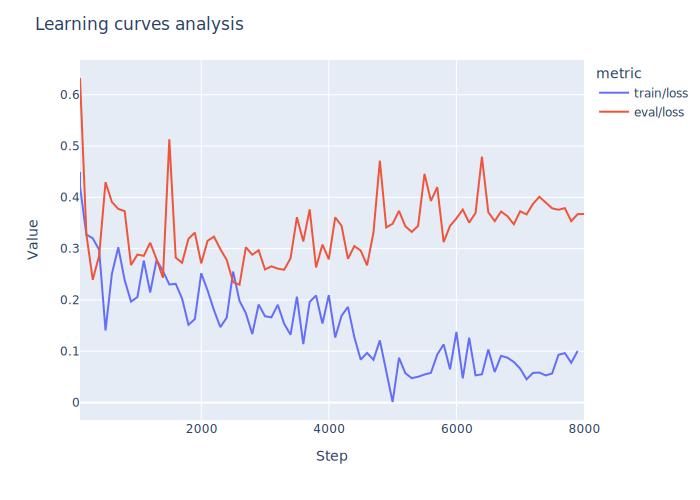

In [46]:
train_logs_df = pd.read_csv(join(training_dirpath, "training_metrics.csv"))
train_loss_df = train_logs_df.loc[train_logs_df["metric"] == "train/loss"].iloc[:80]
eval_loss_df = train_logs_df.loc[train_logs_df["metric"] == "eval/loss"].iloc[:80]
loss_df = pd.concat([train_loss_df, eval_loss_df])

fig = px.line(loss_df, x="step", y="value", color="metric")
fig.update_layout(title="Learning curves analysis", xaxis_title="Step", yaxis_title="Value")
fig.show("svg")

En la gráfica de arriba se muestran las curvas de aprendizaje del modelo. Como se puede observar se ha cometido overfitting aproximadamente en el paso 3000 del entrenamiento ya que la diferencia de las perdidas de entrenamiento y validación van aumentando a partir de ese punto. Con ello, se elige el <strong>checkpoint 2500</strong> del modelo como nuestro modelo final.

### 3.2 Evaluación del modelo final sobre el conjunto de test

In [51]:
model_weights_path = join(training_dirpath, "checkpoint-2500")

test_df = pd.read_csv(join(data_dirpath, 'raw_test.csv'))
test_texts = test_df["text"].values.tolist()
test_labels = test_df["claim"].values.tolist()

tokenizer = transformers.AutoTokenizer.from_pretrained("dccuchile/bert-base-spanish-wwm-cased")
test_encodings = tokenizer(test_texts, truncation=True, padding=True)
test_dataset = trainer.CustomDataset(test_encodings, test_labels)

args = transformers.TrainingArguments(
    output_dir='./dummy',
    logging_dir=join(training_dirpath, 'test-logs')
)

model = transformers.AutoModelForSequenceClassification.from_pretrained(model_weights_path)
tester = transformers.Trainer(
    model=model,
    args=args,
    eval_dataset=test_dataset,
    compute_metrics=trainer.compute_metrics
)

result = tester.predict(test_dataset)
test_df["predict_claim"] = result.predictions.argmax(-1)
test_df.to_csv(join(data_dirpath, "predictions.csv"))
print(result.metrics)

***** Running Prediction *****
  Num examples = 1500
  Batch size = 8


{'test_loss': 0.20558485388755798, 'test_accuracy': 0.9446666666666667, 'test_f1': 0.5257142857142858, 'test_precision': 0.6865671641791045, 'test_recall': 0.42592592592592593, 'test_runtime': 8.6308, 'test_samples_per_second': 173.797, 'test_steps_per_second': 21.783}


Para el análisis de resultados se considera importante que el modelo sea capaz de detectar todas las frases verificables posibles, teniendo el mínimo de falsos negativos. Teniendo esto en cuenta, este modelo no es el mejor puesto que su recall es muy bajo. Sin embargo, hemos obtenido mejores resultados en la métrica 'precision', indicando que el modelo tiene un porcentaje bajo de falsos positivos.

Notas sobre los resultados:

 - Tanto el conjunto de validación como el de test, al ser bastante pequeños, no representan fielmente la población de muestras. Para que los resultados sean concluyentes, debería realizarse una validación cruzada (n-fold cross validation.
 
 - No se ha realizado una validación cruzada debido a la limitación de tiempo y recursos computacionales.

### 3.3 Análisis de errores

In [55]:
errors = test_df.loc[test_df["claim"] != test_df["predict_claim"]]

In [65]:
errors["claim"].value_counts()

1    62
0    21
Name: claim, dtype: int64

In [61]:
for text, claim in zip(errors.text, errors.claim):
    print(text, claim)
    print('-'*100)

El Estatuto da de comer a medio millón de parados. 1
----------------------------------------------------------------------------------------------------
El sistema no es decir al contrario se intensificó. 1
----------------------------------------------------------------------------------------------------
Es verdad que España aquí la comparación tiene un pelín de trampa, sobre todo cuando ponemos aquí a Francia o Alemania, porque son países que van recivido proporcionalmente a su PIB muchísimos menos fondos. 1
----------------------------------------------------------------------------------------------------
Yo lo que diría es que este gobierno, desde luego se ha demostrado que tiene una consideración distinta de las comunidades autónomas y mientras que ha habido una pandemia y una crisis económica, el Gobierno de España ha permitido que Andalucía crezca en su volumen de ingreso en plena crisis económica. 1
----------------------------------------------------------------------------

Está claro que el modelo debe mejorar a la hora de <strong>clasificar positivos</strong> (no ha detectado 62 de 108 positivos en el conjunto de test). Para revertir la situación, estas son algunas posibles mejoras del modelo:

 - El problema principal es el desbalance de clases y la poca cantidad de datos que tenemos. Por tanto se podría considerar utilizar otro tipo de modelos de clasificación más tradicionales (SVM, regresión logística, etc).

 - Si se quiere seguir utilizando arquitecturas BER una posible mejora pasaría por añadir información sobre el etiquetado POS y NER de las frases. Esto se podría conseguir implementando nuevas capas de embeddings para cada carácteristica de entrada.
 
 - Se puede probar a normalizar el texto aplicando lematizaciones, eliminación de stop words, etc para así reducir el vocabulario del corpus.
 